# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Data Cleaning Notebook for Non-Cannabis Crimes

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 1130)
pd.set_option('display.max_columns', 550)
pd.set_option('display.width', 1000)

The "NYPD Complaint Data Historic" dataset downloaded from https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i will be used to build classification models of cannabis crime. This notebook specifically prepares a random sample of crimes that are not specifically cannabis-related, of equivalent size to the universe of cannabis crimes prepared in the '1st_Capstone_Data_Cleaning_cannabis_Daniel_Loew_Final' notebook.  This sample of "non-cannabis crimes" will be concatenated with the universe of cannabis crimes to help identify the primary features that differentiate cannabis crimes from all other crimes in New York City between 2006 and 2018. The  classification models created later in the project will provide a comprehensive image of the coefficients of cannabis arrests within the bounds of the dataset provided by the NYPD.

The NYPD's dataset is first loaded into the 'nyc_crime' DataFrame below.

In [3]:
nyc_data_path = open('/Users/DanLoew/Documents/Academia/Springboard/NYPD_Complaint_Data_Historic.csv', 'r')
nyc_crime = pd.read_csv(nyc_data_path)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Columns 18 and 20 are identified using the .columns attribute.

In [4]:
nyc_crime.columns[18]

'PARKS_NM'

In [5]:
nyc_crime.columns[20]

'HOUSING_PSA'

According to the data dictionary from the NYPD, 'HOUSING_PSA' is the numeric code for housing developments. However, there is already a feature for housing developments called 'HADEVELOPT', which contains clear names for each of the housing developments, so 'HOUSING_PSA' is superfluous. Also, there is no clear crosswalk in the NYPD's data dictionary which connects the numeric codes with the housing development names so the 'HOUSING_PSA' feature is useless.

The 'JURISDICTION_CODE' variable will also be dropped as it had numerical codes that were not labelled in the NYPD's data dictionary, and therefore are meaningless. Also, a jurisdiction code variable named 'JURIS_DESC' with text labels also exists, so the numerical code isn't needed.

The 'PARKS_NM' variable contains which city park each crime occurred in, which could lend predictive power to the classification models planned for this project. Therefore, it will be kept, but the data type needs to be coerced so it is not of mixed type. Therefore the nyc_crime DataFrame is first deleted and then re-loaded with the data type for 'PARKS_NM' coerced to string data type. The 'HOUSING_PSA' and 'JURISDICTION_CODE' features will be dropped after re-loading of the data set into the 'nyc_crime' DataFrame.

In [6]:
del nyc_crime

In [7]:
nyc_data_path = open('/Users/DanLoew/Documents/Academia/Springboard/NYPD_Complaint_Data_Historic.csv', 'r')
nyc_crime = pd.read_csv(nyc_data_path, dtype={'PARKS_NM': str})

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
nyc_crime = nyc_crime.drop(columns=['HOUSING_PSA', 'JURISDICTION_CODE'])

The dtype argument in pd.read_csv should turn all values in 'PARKS_NM' to the string data type, but this needs to be checked on. There may be an issue where the null values in the 'PARKS_NM' column are of a different data type than the non-null values. To check on this, the data type of the first row of non-null values is first looked at to see what data type it is.

In [9]:
type(nyc_crime['PARKS_NM'].dropna().iloc[0])

str

The result returned in cell 9 is good news as it shows that rows with a non-null value for 'PARKS_NM' are of string data type, which is the correct data type. The values of the 'PARKS_NM' feature, and the data type of its null values, are looked at next.

In [10]:
nyc_crime['PARKS_NM'].value_counts().head()

CENTRAL PARK                      1252
FLUSHING MEADOWS CORONA PARK      1016
CONEY ISLAND BEACH & BOARDWALK     805
RIVERSIDE PARK                     495
PROSPECT PARK                      385
Name: PARKS_NM, dtype: int64

In [11]:
type(nyc_crime['PARKS_NM'].isnull().iloc[0])

numpy.bool_

The null values for 'PARKS_NM' will be changed to 'unknown', a string value, later in the notebook. This will ensure 'PARKS_NM' is in one data type and enable it to be binarized so that it can be incorporated into the machine learning classification models later in the project.

# Creation and Introduction to Non-Cannabis Crimes DataFrame

To conduct classification with the cannabis crime DataFrame, a DataFrame of all non-cannabis crimes is first subsetted, for later concatenation with the cannabis crime DataFrame.

In [12]:
nyc_non_cann = nyc_crime[(nyc_crime.PD_CD < 566.0) | (nyc_crime.PD_CD > 570.0)]

To ensure that only non-cannabis arrests are included in the nyc_non_cann DataFrame, the value counts are called on 'PD_DESC', which is the penal code description feature. The cannabis crime descriptions are not returned, as expected. Note that there are several cases having to do with possession, intent to distribute, and being under the influence of a controlled substance. However, the actual controlled substance for these crimes is not specified, so we cannot assume that the substance is cannabis. Therefore, these 'controlled substance' cases are kept in the nyc_non_cann DataFrame.

In [13]:
nyc_non_cann.PD_DESC.value_counts()

ASSAULT 3                                                       564308
HARASSMENT,SUBD 3,4,5                                           513465
AGGRAVATED HARASSMENT 2                                         342102
LARCENY,PETIT FROM STORE-SHOPL                                  302152
HARASSMENT,SUBD 1,CIVILIAN                                      293190
LARCENY,PETIT FROM BUILDING,UN                                  280025
MISCHIEF, CRIMINAL 4, OF MOTOR                                  231630
LARCENY,PETIT FROM AUTO                                         213770
ASSAULT 2,1,UNCLASSIFIED                                        201131
CRIMINAL MISCHIEF,UNCLASSIFIED 4                                183862
LARCENY,GRAND FROM BUILDING (NON-RESIDENCE) UNATTENDED          131950
CONTROLLED SUBSTANCE, POSSESSI                                  121812
CRIMINAL MISCHIEF 4TH, GRAFFIT                                  121373
ROBBERY,OPEN AREA UNCLASSIFIED                                  108987
LARCEN

Now that the 'nyc_non_cann' DataFrame is created, the 'nyc_crime' DataFrame is no longer needed and can be deleted to free up memory.

In [14]:
del nyc_crime

The type of 'nyc_non_cann' is also called to confirm that it is a DataFrame.

In [15]:
type(nyc_non_cann)

pandas.core.frame.DataFrame

Below is a first look at the reduced DataFrame of just non-cannabis crimes using .head(), .tail(), .shape, .info(), .describe(), and .columns.

In [16]:
nyc_non_cann.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,577055921,12/31/2018,19:00:00,12/31/2018,19:35:00,75.0,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,NaN,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,NaN,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,NaN,18-24,BLACK,M
1,311304275,12/31/2018,15:00:00,12/31/2018,16:00:00,41.0,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,BRONX,INSIDE,STREET,N.Y. POLICE DEPT,NaN,NaN,1015845.0,236500.0,25-44,WHITE HISPANIC,F,NaN,40.815765,-73.885857,"(40.815765327, -73.885857339)",PATROL BORO BRONX,NaN,18-24,WHITE HISPANIC,F
2,427481098,12/31/2018,18:00:00,12/31/2018,18:30:00,14.0,12/31/2018,109,GRAND LARCENY,410.0,"LARCENY,GRAND FROM RETAIL STORE, UNATTENDED",COMPLETED,FELONY,MANHATTAN,INSIDE,CLOTHING/BOUTIQUE,N.Y. POLICE DEPT,NaN,NaN,988318.0,212070.0,NaN,NaN,NaN,NaN,40.748767,-73.985320,"(40.748767014, -73.985319659)",PATROL BORO MAN SOUTH,NaN,18-24,UNKNOWN,F
3,212387335,12/31/2018,16:50:00,12/31/2018,17:00:00,81.0,12/31/2018,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",ATTEMPTED,FELONY,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,NaN,NaN,1006734.0,188708.0,25-44,BLACK,M,NaN,40.684616,-73.918933,"(40.684616294, -73.918932657)",PATROL BORO BKLYN NORTH,NaN,25-44,BLACK,M
4,629543587,12/31/2018,00:45:00,12/31/2018,01:00:00,26.0,12/31/2018,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,OTHER,N.Y. POLICE DEPT,NaN,NaN,994261.0,232730.0,18-24,BLACK,F,NaN,40.805469,-73.963840,"(40.805468548, -73.963840045)",PATROL BORO MAN NORTH,NaN,25-44,WHITE HISPANIC,M


In [17]:
nyc_non_cann.tail()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
6500865,608025222,NaN,18:00:00,NaN,NaN,23.0,06/06/2014,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",COMPLETED,VIOLATION,MANHATTAN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,NaN,NaN,1001924.0,227875.0,NaN,BLACK,F,NaN,40.792131,-73.936173,"(40.792130892, -73.936172792)",PATROL BORO MAN NORTH,NaN,25-44,BLACK,M
6500866,347331285,NaN,23:55:00,11/21/2014,00:05:00,7.0,11/21/2014,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,MANHATTAN,FRONT OF,STREET,N.Y. POLICE DEPT,NaN,NaN,988082.0,200814.0,NaN,UNKNOWN,M,NaN,40.717872,-73.986178,"(40.717872161, -73.986177815)",PATROL BORO MAN SOUTH,NaN,25-44,WHITE HISPANIC,M
6500867,129237914,NaN,17:50:00,NaN,NaN,25.0,08/22/2015,341,PETIT LARCENY,333.0,"LARCENY,PETIT FROM STORE-SHOPL",COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,COMMERCIAL BUILDING,N.Y. POLICE DEPT,NaN,NaN,1001315.0,230818.0,NaN,BLACK,M,NaN,40.800210,-73.938365,"(40.800209825, -73.938364683)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,D
6500868,230239029,NaN,09:25:00,02/20/2011,09:35:00,106.0,02/20/2011,351,CRIMINAL MISCHIEF & RELATED OF,259.0,"CRIMINAL MISCHIEF,UNCLASSIFIED 4",COMPLETED,MISDEMEANOR,QUEENS,INSIDE,RESIDENCE-HOUSE,N.Y. POLICE DEPT,NaN,NaN,1037260.0,184030.0,18-24,ASIAN / PACIFIC ISLANDER,M,NaN,40.671646,-73.808905,"(40.671646094, -73.808904508)",PATROL BORO QUEENS SOUTH,NaN,45-64,ASIAN / PACIFIC ISLANDER,F
6500869,215287089,NaN,01:00:00,03/06/2015,14:00:00,72.0,03/06/2015,351,CRIMINAL MISCHIEF & RELATED OF,254.0,"MISCHIEF, CRIMINAL 4, OF MOTOR",COMPLETED,MISDEMEANOR,BROOKLYN,FRONT OF,STREET,N.Y. POLICE DEPT,NaN,NaN,979853.0,171117.0,NaN,NaN,NaN,NaN,40.636360,-74.015844,"(40.636360331, -74.015843892)",PATROL BORO BKLYN SOUTH,NaN,45-64,ASIAN / PACIFIC ISLANDER,F


In [18]:
nyc_non_cann.shape

(6274557, 33)

In [19]:
nyc_non_cann.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6274557 entries, 0 to 6500869
Data columns (total 33 columns):
CMPLNT_NUM           int64
CMPLNT_FR_DT         object
CMPLNT_FR_TM         object
CMPLNT_TO_DT         object
CMPLNT_TO_TM         object
ADDR_PCT_CD          float64
RPT_DT               object
KY_CD                int64
OFNS_DESC            object
PD_CD                float64
PD_DESC              object
CRM_ATPT_CPTD_CD     object
LAW_CAT_CD           object
BORO_NM              object
LOC_OF_OCCUR_DESC    object
PREM_TYP_DESC        object
JURIS_DESC           object
PARKS_NM             object
HADEVELOPT           object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP       object
SUSP_RACE            object
SUSP_SEX             object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon              object
PATROL_BORO          object
STATION_NAME         object
VIC_AGE_GROUP        object
VIC_RACE      

In [20]:
nyc_non_cann.describe(include='all')

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
count,6.274557e+06,6273904,6274510,4740406,4744633,6.274173e+06,6274557,6.274557e+06,6255752,6.274557e+06,6274557,6274550,6274557,6269720,4971825,6244081,6274557,18474,296131,6.258145e+06,6.258145e+06,1871320,3239373,3106096,140566.000000,6.258145e+06,6.258145e+06,6258145,6274101,140566,4824489,6274306,6274307
unique,NaN,7605,1441,6001,1441,NaN,4748,NaN,69,NaN,409,2,3,5,4,72,25,1096,278,NaN,NaN,95,8,3,NaN,NaN,NaN,115325,8,371,191,8,4
top,NaN,01/01/2010,12:00:00,07/05/2018,12:00:00,NaN,05/29/2007,NaN,PETIT LARCENY,NaN,ASSAULT 3,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,STREET,N.Y. POLICE DEPT,CENTRAL PARK,CASTLE HILL,NaN,NaN,25-44,BLACK,M,NaN,NaN,NaN,"(40.750430768, -73.989282176)",PATROL BORO BRONX,125 STREET,25-44,UNKNOWN,F
freq,NaN,2345,173316,1335,86050,NaN,1823,NaN,1072782,NaN,564308,6164277,3474130,1863446,3238858,1973101,5596162,1233,6223,NaN,NaN,781373,1204953,1961025,NaN,NaN,NaN,20667,1322027,7298,2108018,1966579,2538296
mean,5.500506e+08,NaN,NaN,NaN,NaN,6.366613e+01,NaN,2.970981e+02,NaN,4.104938e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.004735e+06,2.066541e+05,NaN,NaN,NaN,13.695965,4.073385e+01,-7.392605e+01,NaN,NaN,NaN,NaN,NaN,NaN
std,2.597549e+08,NaN,NaN,NaN,NaN,3.468681e+01,NaN,1.509578e+02,NaN,2.201011e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.199232e+04,3.156369e+04,NaN,NaN,NaN,12.512247,8.653189e-02,7.931080e-02,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000001e+08,NaN,NaN,NaN,NaN,1.000000e+00,NaN,1.020000e+02,NaN,1.010000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.110000e+02,1.110000e+02,NaN,NaN,NaN,1.000000,4.011271e+01,-7.751921e+01,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.252128e+08,NaN,NaN,NaN,NaN,4.000000e+01,NaN,1.140000e+02,NaN,2.540000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.914240e+05,1.842360e+05,NaN,NaN,NaN,3.000000,4.067229e+01,-7.397411e+01,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.500043e+08,NaN,NaN,NaN,NaN,6.600000e+01,NaN,3.410000e+02,NaN,3.570000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.004201e+06,2.054050e+05,NaN,NaN,NaN,11.000000,4.073041e+01,-7.392799e+01,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.749508e+08,NaN,NaN,NaN,NaN,1.000000e+02,NaN,3.510000e+02,NaN,6.380000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.016685e+06,2.344920e+05,NaN,NaN,NaN,30.000000,4.081030e+01,-7.388292e+01,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
nyc_non_cann.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'PARKS_NM', 'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'], dtype='object')

# Null Data Values

The following section focuses on filling and dropping null values, in that order. First, the .shape attribute is called on the 'nyc_non_cann' DataFrame as a benchmark for the number of rows and features in the DataFrame.

In [22]:
nyc_non_cann.shape

(6274557, 33)

Features with null values are identified in the two cells below. Both .isnull().sum() and .isna().sum() chained methods are called to identify all types of null values. The null value sums match across both chained methods.

In [23]:
nyc_non_cann.isnull().sum()

CMPLNT_NUM                 0
CMPLNT_FR_DT             653
CMPLNT_FR_TM              47
CMPLNT_TO_DT         1534151
CMPLNT_TO_TM         1529924
ADDR_PCT_CD              384
RPT_DT                     0
KY_CD                      0
OFNS_DESC              18805
PD_CD                      0
PD_DESC                    0
CRM_ATPT_CPTD_CD           7
LAW_CAT_CD                 0
BORO_NM                 4837
LOC_OF_OCCUR_DESC    1302732
PREM_TYP_DESC          30476
JURIS_DESC                 0
PARKS_NM             6256083
HADEVELOPT           5978426
X_COORD_CD             16412
Y_COORD_CD             16412
SUSP_AGE_GROUP       4403237
SUSP_RACE            3035184
SUSP_SEX             3168461
TRANSIT_DISTRICT     6133991
Latitude               16412
Longitude              16412
Lat_Lon                16412
PATROL_BORO              456
STATION_NAME         6133991
VIC_AGE_GROUP        1450068
VIC_RACE                 251
VIC_SEX                  250
dtype: int64

In [24]:
nyc_non_cann.isna().sum()

CMPLNT_NUM                 0
CMPLNT_FR_DT             653
CMPLNT_FR_TM              47
CMPLNT_TO_DT         1534151
CMPLNT_TO_TM         1529924
ADDR_PCT_CD              384
RPT_DT                     0
KY_CD                      0
OFNS_DESC              18805
PD_CD                      0
PD_DESC                    0
CRM_ATPT_CPTD_CD           7
LAW_CAT_CD                 0
BORO_NM                 4837
LOC_OF_OCCUR_DESC    1302732
PREM_TYP_DESC          30476
JURIS_DESC                 0
PARKS_NM             6256083
HADEVELOPT           5978426
X_COORD_CD             16412
Y_COORD_CD             16412
SUSP_AGE_GROUP       4403237
SUSP_RACE            3035184
SUSP_SEX             3168461
TRANSIT_DISTRICT     6133991
Latitude               16412
Longitude              16412
Lat_Lon                16412
PATROL_BORO              456
STATION_NAME         6133991
VIC_AGE_GROUP        1450068
VIC_RACE                 251
VIC_SEX                  250
dtype: int64

A list of features with null values are identified in the next cell, for easy reference while writing code for filling and dropping null values.

In [25]:
null_value_columns = list(nyc_non_cann.columns[(nyc_non_cann.isnull().sum()>0) | (nyc_non_cann.isna().sum()>0)])
null_value_columns

['CMPLNT_FR_DT',
 'CMPLNT_FR_TM',
 'CMPLNT_TO_DT',
 'CMPLNT_TO_TM',
 'ADDR_PCT_CD',
 'OFNS_DESC',
 'CRM_ATPT_CPTD_CD',
 'BORO_NM',
 'LOC_OF_OCCUR_DESC',
 'PREM_TYP_DESC',
 'PARKS_NM',
 'HADEVELOPT',
 'X_COORD_CD',
 'Y_COORD_CD',
 'SUSP_AGE_GROUP',
 'SUSP_RACE',
 'SUSP_SEX',
 'TRANSIT_DISTRICT',
 'Latitude',
 'Longitude',
 'Lat_Lon',
 'PATROL_BORO',
 'STATION_NAME',
 'VIC_AGE_GROUP',
 'VIC_RACE',
 'VIC_SEX']

Objects are created in the next sequence of cells which are assigned to a list of feature name(s) that have null values. These objects will be used in the following sequence of cells for filling the null values of these features. These features need their null values filled in order to create binarized features for the classification model of cannabis crimes and non-cannabis crimes.

In [26]:
not_public_housing_related = ['HADEVELOPT']

In [27]:
complaint_to_date = ['CMPLNT_TO_DT']

In [28]:
complaint_to_time = ['CMPLNT_TO_TM']

In [29]:
fill_na_cols_not_transit_related = ['TRANSIT_DISTRICT', 'STATION_NAME']

In [30]:
fill_na_cols_unknown = ['ADDR_PCT_CD', 'OFNS_DESC', 'CRM_ATPT_CPTD_CD', 'BORO_NM', 'LOC_OF_OCCUR_DESC', 
                        'PREM_TYP_DESC', 'PARKS_NM', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'PATROL_BORO', 'VIC_AGE_GROUP', 
                        'VIC_RACE', 'VIC_SEX']

In [31]:
drop_na_cols = ['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lat_Lon']

The next sequence of cells fill null values with the .fillna() method with feature-specific values.

In [32]:
nyc_non_cann[complaint_to_date] = nyc_non_cann[complaint_to_date].fillna(value='00/00/0000', axis=1)

In [33]:
nyc_non_cann[complaint_to_time] = nyc_non_cann[complaint_to_time].fillna(value='00:00:00', axis=1)

In [34]:
nyc_non_cann[not_public_housing_related] = nyc_non_cann[not_public_housing_related].fillna(value='not_housing_devpt_crime', axis=1)

In [35]:
nyc_non_cann[fill_na_cols_not_transit_related] = nyc_non_cann[fill_na_cols_not_transit_related].fillna(value='not_transit_related', axis=1)

In [36]:
nyc_non_cann[fill_na_cols_unknown] = nyc_non_cann[fill_na_cols_unknown].fillna(value='unknown', axis=1)

The next cell drops rows that have missing start date/time and/or geo-coordinate values. This amounts to 17,104 out of 6,274,557 rows (or 0.3%), which is an acceptable loss for a uniform DataFrame with no missing values across all features.

In [37]:
nyc_non_cann = nyc_non_cann.dropna(axis=0)

In [38]:
nyc_non_cann.shape

(6257453, 33)

It can be seen below that there are no longer any missing values in the DataFrame. Both .isnull().sum() and .isna().sum() are called to ensure all types of null values have been filled or dropped.

In [39]:
nyc_non_cann.isnull().sum()

CMPLNT_NUM           0
CMPLNT_FR_DT         0
CMPLNT_FR_TM         0
CMPLNT_TO_DT         0
CMPLNT_TO_TM         0
ADDR_PCT_CD          0
RPT_DT               0
KY_CD                0
OFNS_DESC            0
PD_CD                0
PD_DESC              0
CRM_ATPT_CPTD_CD     0
LAW_CAT_CD           0
BORO_NM              0
LOC_OF_OCCUR_DESC    0
PREM_TYP_DESC        0
JURIS_DESC           0
PARKS_NM             0
HADEVELOPT           0
X_COORD_CD           0
Y_COORD_CD           0
SUSP_AGE_GROUP       0
SUSP_RACE            0
SUSP_SEX             0
TRANSIT_DISTRICT     0
Latitude             0
Longitude            0
Lat_Lon              0
PATROL_BORO          0
STATION_NAME         0
VIC_AGE_GROUP        0
VIC_RACE             0
VIC_SEX              0
dtype: int64

In [40]:
nyc_non_cann.isna().sum()

CMPLNT_NUM           0
CMPLNT_FR_DT         0
CMPLNT_FR_TM         0
CMPLNT_TO_DT         0
CMPLNT_TO_TM         0
ADDR_PCT_CD          0
RPT_DT               0
KY_CD                0
OFNS_DESC            0
PD_CD                0
PD_DESC              0
CRM_ATPT_CPTD_CD     0
LAW_CAT_CD           0
BORO_NM              0
LOC_OF_OCCUR_DESC    0
PREM_TYP_DESC        0
JURIS_DESC           0
PARKS_NM             0
HADEVELOPT           0
X_COORD_CD           0
Y_COORD_CD           0
SUSP_AGE_GROUP       0
SUSP_RACE            0
SUSP_SEX             0
TRANSIT_DISTRICT     0
Latitude             0
Longitude            0
Lat_Lon              0
PATROL_BORO          0
STATION_NAME         0
VIC_AGE_GROUP        0
VIC_RACE             0
VIC_SEX              0
dtype: int64

The 'null_value_columns' object is called again to verify that there are no columns left with null values. As can be seen, an empty list is returned.

In [41]:
null_value_columns = list(nyc_non_cann.columns[(nyc_non_cann.isnull().sum()>0) | (nyc_non_cann.isna().sum()>0)])
null_value_columns

[]

# Creation of DateTime Features

This section creates datetime and duration features from the crime start date, crime start time, crime end date, and crime end time features. First, the values of the respective component date and time variables are examined, and then combined into datetime formatted features. The .head() method is called to confirm that the 'date_time_start' and 'date_time_end' features are in the correct datetime format.

In [42]:
nyc_non_cann.CMPLNT_FR_DT.value_counts().head()

01/01/2010    2345
01/01/2008    2285
01/01/2014    2278
01/01/2011    2276
01/01/2007    2274
Name: CMPLNT_FR_DT, dtype: int64

In [43]:
nyc_non_cann.CMPLNT_FR_TM.value_counts().head()

12:00:00    172835
15:00:00    145005
18:00:00    139121
20:00:00    131354
17:00:00    129390
Name: CMPLNT_FR_TM, dtype: int64

In [44]:
nyc_non_cann['date_time_start'] = pd.to_datetime(nyc_non_cann['CMPLNT_FR_DT'] + ' ' + nyc_non_cann['CMPLNT_FR_TM'], errors='coerce')

In [45]:
nyc_non_cann.date_time_start.head()

0   2018-12-31 19:00:00
1   2018-12-31 15:00:00
2   2018-12-31 18:00:00
3   2018-12-31 16:50:00
4   2018-12-31 00:45:00
Name: date_time_start, dtype: datetime64[ns]

In [46]:
nyc_non_cann.CMPLNT_TO_DT.value_counts().head()

00/00/0000    1528193
07/05/2018       1335
01/01/2014       1333
10/17/2014       1314
06/01/2016       1310
Name: CMPLNT_TO_DT, dtype: int64

In [47]:
nyc_non_cann.CMPLNT_TO_TM.value_counts().head()

00:00:00    1537654
12:00:00      85830
15:00:00      77008
08:00:00      75552
09:00:00      73168
Name: CMPLNT_TO_TM, dtype: int64

In [48]:
nyc_non_cann['date_time_end'] = pd.to_datetime(nyc_non_cann['CMPLNT_TO_DT'] + ' ' + nyc_non_cann['CMPLNT_TO_TM'], errors='coerce')

In [49]:
nyc_non_cann.date_time_end.head()

0   2018-12-31 19:35:00
1   2018-12-31 16:00:00
2   2018-12-31 18:30:00
3   2018-12-31 17:00:00
4   2018-12-31 01:00:00
Name: date_time_end, dtype: datetime64[ns]

A duration feature is created from the 'date_time_start' and 'date_time_end' features to measure the length of time a non-cannabis crime was recorded as having taken. The majority of crimes only have a 'date_time_start' value, but some transpired over a period of time. After the feature is created, the most frequent values are shown.

In [50]:
nyc_non_cann['duration'] = nyc_non_cann.date_time_end - nyc_non_cann.date_time_start
nyc_non_cann['duration'].value_counts().head()

00:05:00    618855
00:10:00    450168
00:15:00    284512
00:30:00    264136
00:00:00    235452
Name: duration, dtype: int64

Because so many cases had no values for the native features 'CMPLNT_TO_DT' and 'CMPLNT_TO_TM', the presence of any null values for 'duration' is first checked using both the chained .isna().sum() and .isnull().sum() methods.

In [51]:
nyc_non_cann['duration'].isna().sum()

1529637

In [52]:
nyc_non_cann['duration'].isnull().sum()

1529637

The object 'duration_fill' is created in the next cell which is assigned to the 'duration' feature name. This object will be used in the following cell for the purpose of editing the null values of 'duration' to the specific value of zero days, hours, minutes, and seconds. The most frequent values of 'duration' are then called.

In [53]:
duration_fill = ['duration']

In [54]:
nyc_non_cann[duration_fill] = nyc_non_cann[duration_fill].fillna('0 days 00:00:00', axis=1)

In [55]:
nyc_non_cann['duration'].value_counts().head()

0 days 00:00:00    1529637
0 days 00:05:00     618855
0 days 00:10:00     450168
0 days 00:15:00     284512
0 days 00:30:00     264136
Name: duration, dtype: int64

The presence of null values is double-checked. There are no longer any null values.

In [56]:
nyc_non_cann['duration'].isna().sum()

0

In [57]:
nyc_non_cann['duration'].isnull().sum()

0

The data type of 'duration' is verified as Timedelta and is converted into the integer data type feature 'duration_days', in order to identify just how many days a case transpires over. The most frequent value counts are called for 'duration_days', and the data type of the feature is confirmed as being of integer data type. 

In [58]:
type(nyc_non_cann['duration'].iloc[0])

pandas._libs.tslibs.timedeltas.Timedelta

In [59]:
nyc_non_cann['duration_days'] = (nyc_non_cann['duration'] / np.timedelta64(1, 'D')).astype(int)
nyc_non_cann['duration_days'].value_counts().head()

0    5714071
1     130245
2      65582
3      37046
4      24503
Name: duration_days, dtype: int64

In [60]:
type(nyc_non_cann['duration_days'].iloc[0])

numpy.int64

Because the 'duration' feature is of Timedelta format, it cannot be used by machine learning classifiers, and is therefore dropped in the following cell. The 'duration_days' feature will be used by the machine learning classifiers.

In [61]:
nyc_non_cann = nyc_non_cann.drop(columns = 'duration')

# Extraction of Granular DateTime Features

The next section extracts year, month, date, hour, minute and seconds features from the 'date_time_start' datetime feature. These will be used for EDA purposes, as features for the classification models, and for building other time-related features.

In [62]:
nyc_non_cann['start_year'] = nyc_non_cann.date_time_start.dt.year

The following command checks the year range in the data. Note that there are a many cases that fall outside of the NYPD's dataset's stated year range of 2006-2018. These cases will be dropped below.

In [63]:
nyc_non_cann.start_year.value_counts()

2007.0    515185
2008.0    507701
2006.0    496999
2009.0    486959
2010.0    485070
2012.0    483628
2013.0    479176
2014.0    475723
2011.0    474266
2015.0    466564
2016.0    465481
2017.0    454931
2018.0    446940
2005.0     10447
2004.0      2080
2003.0      1549
2002.0      1070
2001.0      1043
2000.0       900
1999.0       357
1998.0       238
1997.0       138
1996.0       128
1995.0        85
1994.0        73
1993.0        55
1992.0        43
1986.0        35
1991.0        32
1990.0        27
1966.0        26
1985.0        25
1989.0        22
1987.0        19
1988.0        17
1981.0        14
1968.0        14
1967.0        14
1980.0        13
1977.0        12
1975.0        12
1973.0        12
1912.0        11
1914.0        11
1971.0        11
1978.0        10
1984.0        10
1979.0        10
1913.0         9
1910.0         9
1915.0         9
1960.0         9
1972.0         8
1983.0         8
1982.0         8
1974.0         8
1911.0         7
1969.0         7
1916.0        

In [64]:
nyc_non_cann['start_month'] = nyc_non_cann.date_time_start.dt.month

The following command checks the month range in the data. All 12 calendar months are represented, and there are no unusual values.

In [65]:
nyc_non_cann.start_month.value_counts()

7.0     561635
8.0     560370
5.0     550216
10.0    547585
6.0     542589
9.0     537514
3.0     512923
1.0     510992
11.0    499414
4.0     494633
12.0    493467
2.0     446019
Name: start_month, dtype: int64

In [66]:
nyc_non_cann['start_day'] = nyc_non_cann.date_time_start.dt.day

The following command checks the day range in the data. All 31 calendar days are represented, and there are no unusual values.

In [67]:
nyc_non_cann.start_day.value_counts()

1.0     264988
15.0    214159
20.0    212207
10.0    209445
5.0     207322
12.0    205921
17.0    205397
18.0    204226
2.0     204022
21.0    203886
14.0    203873
13.0    203327
3.0     203154
16.0    203009
7.0     202952
4.0     202890
6.0     202880
22.0    202823
9.0     202778
11.0    202775
23.0    202653
28.0    202297
8.0     201973
19.0    200294
27.0    200236
24.0    199874
25.0    199090
26.0    197876
29.0    186875
30.0    186834
31.0    117321
Name: start_day, dtype: int64

In [68]:
nyc_non_cann['start_hour'] = nyc_non_cann.date_time_start.dt.hour

The following command checks the hour range in the data. All 24 hours are represented, and there are no unusual values. Note that the hour range is in 24-hour format, and midnight is represented as zero.

In [69]:
nyc_non_cann['start_hour'].value_counts()

15.0    377617
18.0    366101
17.0    358934
16.0    358002
12.0    351185
19.0    348271
20.0    344260
14.0    333418
21.0    311413
0.0     299881
22.0    295368
13.0    295044
23.0    275249
11.0    251240
10.0    247226
9.0     238840
8.0     217850
1.0     213389
2.0     174586
3.0     148076
7.0     134672
4.0     130532
6.0      94124
5.0      92079
Name: start_hour, dtype: int64

In [70]:
nyc_non_cann['start_minute'] = nyc_non_cann.date_time_start.dt.minute

The following command checks the minute range in the data. There are no unusual values. Note that the 60th minute is represented as zero.

In [71]:
nyc_non_cann['start_minute'].value_counts()

0.0     2286396
30.0    1083732
45.0     317781
15.0     315380
20.0     271610
50.0     266188
40.0     253270
10.0     212857
25.0     129776
5.0      120333
35.0     117507
55.0     114696
1.0       95576
18.0      19195
48.0      18215
8.0       18193
38.0      18014
58.0      17797
28.0      17535
12.0      16857
23.0      15517
13.0      15031
43.0      14992
22.0      14951
17.0      14915
42.0      14716
24.0      14688
14.0      14667
47.0      14639
7.0       14533
2.0       14501
59.0      14421
27.0      14403
37.0      14350
3.0       14330
9.0       14144
53.0      14008
57.0      13959
44.0      13875
19.0      13853
6.0       13778
52.0      13760
33.0      13752
36.0      13744
32.0      13519
26.0      13465
39.0      13434
34.0      13293
49.0      13245
16.0      13155
4.0       13098
54.0      13080
11.0      12991
29.0      12844
46.0      12660
56.0      12616
21.0      11732
41.0      11085
51.0      10827
31.0       9878
Name: start_minute, dtype: int64

In [72]:
nyc_non_cann['start_seconds'] = nyc_non_cann.date_time_start.dt.second

The following command checks the second range in the data.

In [73]:
nyc_non_cann['start_seconds'].value_counts()

0.0    6257356
1.0          1
Name: start_seconds, dtype: int64

# Dropping Year Outliers

The next part drops cases outside of the year range of the dataset that is stated on the NYC Open Data website, that is, earlier than 2006.

The code in the following two cells create a Boolean Series object named 'years_to_keep' by identifying the cases that have 'start_year' values after 2005, and this Boolean Series is then used to create a new feature of integer data type called 'years_to_keep'.  The cases with a value of zero for the 'years_to_keep' feature are dropped.

In [74]:
years_to_keep = (nyc_non_cann.start_year > 2005)

In [75]:
nyc_non_cann['years_to_keep'] = years_to_keep.astype(int)

18,830 cases are identified as occurring before 2006, the stated year range of the data set.

In [76]:
nyc_non_cann.years_to_keep.value_counts()

1    6238623
0      18830
Name: years_to_keep, dtype: int64

These 18,830 cases are dropped.

In [77]:
nyc_non_cann.drop(nyc_non_cann[nyc_non_cann.years_to_keep == 0].index, inplace=True)

In [78]:
nyc_non_cann['years_to_keep'].value_counts()

1    6238623
Name: years_to_keep, dtype: int64

The 'years_to_keep' feature is dropped from the DataFrame, as it is no longer needed.

In [79]:
nyc_non_cann = nyc_non_cann.drop(columns = 'years_to_keep')

Value counts are examined for the 'start_year' feature to make sure all cases before 2006 are dropped.

In [80]:
nyc_non_cann['start_year'].value_counts()

2007.0    515185
2008.0    507701
2006.0    496999
2009.0    486959
2010.0    485070
2012.0    483628
2013.0    479176
2014.0    475723
2011.0    474266
2015.0    466564
2016.0    465481
2017.0    454931
2018.0    446940
Name: start_year, dtype: int64

Just to make sure that there are no cases with a 'date_time_end' value prior to 2006, the year datetime object is extracted into a new feature named 'end_year'. There are three cases with a 'date_time_end' value prior to, or after, the stated date range of the dataset. These three cases are dropped in a similar fashion as cases with  'date_time_start' values outside of the stated date range of the dataset.

In [81]:
nyc_non_cann['end_year'] = nyc_non_cann.date_time_end.dt.year
nyc_non_cann['end_year'].value_counts()

2018.0    389370
2016.0    387625
2017.0    385314
2014.0    381101
2015.0    377422
2013.0    373427
2012.0    362337
2008.0    350543
2010.0    348271
2011.0    347432
2007.0    346146
2009.0    345193
2006.0    319960
2090.0         1
2081.0         1
2001.0         1
Name: end_year, dtype: int64

In [82]:
years_to_drop = (nyc_non_cann.end_year < 2006) | (nyc_non_cann.end_year > 2018)

In [83]:
nyc_non_cann['years_to_drop'] = years_to_drop.astype(int)

In [84]:
nyc_non_cann.years_to_drop.value_counts()

0    6238620
1          3
Name: years_to_drop, dtype: int64

In [85]:
nyc_non_cann.drop(nyc_non_cann[nyc_non_cann.years_to_drop == 1].index, inplace=True)

In [86]:
nyc_non_cann['years_to_drop'].value_counts()

0    6238620
Name: years_to_drop, dtype: int64

The 'years_to_drop' column is dropped from the DataFrame, as it is no longer needed.

In [87]:
nyc_non_cann = nyc_non_cann.drop(columns = 'years_to_drop')

Value counts are examined for the 'end_year' feature to make sure all cases outside of the stated date range of the dataset are dropped.

In [88]:
nyc_non_cann['end_year'].value_counts()

2018.0    389370
2016.0    387625
2017.0    385314
2014.0    381101
2015.0    377422
2013.0    373427
2012.0    362337
2008.0    350543
2010.0    348271
2011.0    347432
2007.0    346146
2009.0    345193
2006.0    319960
Name: end_year, dtype: int64

Because the 'duration_days' feature uses 'date_time_end' in its valuation of the number of days a crime takes to occur, extracting datetime features from 'date_time_end' is not needed. In other words, the 'duration_days' feature stores the information of the date and time that the crime ends. Therefore, the 'date_time_end' feature will not be used in the feature set for classification models, and is here dropped from the DataFrame. 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', and 'end_year' are also no longer needed.

In [89]:
nyc_non_cann = nyc_non_cann.drop(columns = ['date_time_end', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'end_year'])

# Reported Date of Crime

The 'RPT_DT', or date that the crime was reported by the NYPD, sometimes differs from the date stored in the 'CMPLNT_FR_DT' feature, as can be seen in the following two cells.

In [90]:
round((nyc_non_cann['CMPLNT_FR_DT'] == nyc_non_cann['RPT_DT']).value_counts(normalize=True), 3)*100

True     64.3
False    35.7
dtype: float64

In [91]:
(nyc_non_cann['CMPLNT_FR_DT'] == nyc_non_cann['RPT_DT']).value_counts()

True     4013853
False    2224767
dtype: int64

'RPT_DT' differs from 'CMPLNT_FR_DT' a rather large 35.9% of the time, so this differing could be a predictive feature. Before creating this predictive feature, 'RPT_DT' is first converted into a DateTime feature and then year, month, and date features are extracted from it so that any outliers outside of the NYPD's stated date range can be identified and dropped. 

In [92]:
nyc_non_cann['rpt_dt_datetime'] = pd.to_datetime(nyc_non_cann['RPT_DT'])

In [93]:
nyc_non_cann.rpt_dt_datetime.head()

0   2018-12-31
1   2018-12-31
2   2018-12-31
3   2018-12-31
4   2018-12-31
Name: rpt_dt_datetime, dtype: datetime64[ns]

The next section extracts year, month, and date features from the 'rpt_dt_datetime' datetime feature. These will be used to identify any possible outliers.

In [94]:
nyc_non_cann['rpt_start_year'] = nyc_non_cann.rpt_dt_datetime.dt.year

The following cell checks the year range in the data. All values fall within the valid range of 2006-2018.

In [95]:
nyc_non_cann.rpt_start_year.value_counts()

2007    513540
2008    507116
2009    487888
2006    486261
2010    484086
2012    482973
2013    480367
2014    474915
2011    473703
2015    466577
2016    466567
2018    457701
2017    456926
Name: rpt_start_year, dtype: int64

In [96]:
nyc_non_cann['rpt_start_month'] = nyc_non_cann.rpt_dt_datetime.dt.month

The following cell checks the month range in the data. All 12 calendar months are represented, and there are no unusual values.

In [97]:
nyc_non_cann.rpt_start_month.value_counts()

8     561174
7     559097
5     549705
10    547715
6     540248
9     536234
3     513797
1     500558
11    499742
4     494419
12    490730
2     445201
Name: rpt_start_month, dtype: int64

In [98]:
nyc_non_cann['rpt_start_day'] = nyc_non_cann.rpt_dt_datetime.dt.day

The following cell checks the day range in the data. All 31 calendar days are represented, and there are no unusual values.

In [99]:
nyc_non_cann.rpt_start_day.value_counts()

20    208766
18    207822
17    207528
21    207521
5     207247
12    206858
10    206687
1     206502
15    206502
13    206268
16    206232
11    206184
9     206042
6     206035
22    205745
14    205442
23    205068
8     204972
19    204942
7     204689
2     204274
28    203236
27    202419
3     202261
4     201736
24    201227
26    200762
25    198258
29    192159
30    188706
31    116530
Name: rpt_start_day, dtype: int64

Now that outlier values in 'RPT_DT' are checked for, the component features are no longer needed and can be dropped.

In [100]:
nyc_non_cann = nyc_non_cann.drop(columns = ['rpt_dt_datetime', 'rpt_start_year', 'rpt_start_month', 'rpt_start_day'])

Because 'RPT_DT' differs from 'CMPLNT_FR_DT' 35.7% of the time (as seen in cell 90 above), and this differing could be predictive, a new binary feature called 'rpt_cmplnt_dt_match' is created. The binary feature 'rpt_cmplnt_dt_match' is created below, first by creating a Boolean mask Series object of 'True' and 'False' values based on whether the values of 'CMPLNT_FR_DT' and 'RPT_DT' match, and then the creation of the integer type feature by assigning the 'rpt_cmplnt_dt_match' object to it. This results in a value of '1' for matches between the two dates, and '0' for mismatches.

In [101]:
rpt_cmplnt_dt_match = nyc_non_cann['CMPLNT_FR_DT'] == nyc_non_cann['RPT_DT']

In [102]:
nyc_non_cann['rpt_cmplnt_dt_match'] = rpt_cmplnt_dt_match.astype(int)
nyc_non_cann['rpt_cmplnt_dt_match'].value_counts()

1    4013853
0    2224767
Name: rpt_cmplnt_dt_match, dtype: int64

Because 'RPT_DT' contains the same information as 'CMPLNT_FR_DT' 64.3% of the time, the 'RPT_DT' feature itself will be dropped later in the notebook so as to avoid duplication of information that could theoretically adversely affect the classification models.

# Creation of Time Window Features

In the next section, the 'CMPLNT_FR_TM' feature is used to create different time window features to include in the classification models' feature set, which will allow seeing how crime frequency differs throughout the average day. The start time feature 'CMPLNT_FR_TM' is used to define the time windows instead of the 'CMPLNT_TO_TM' feature. This choice was made because all cases have a start time in the DataFrame but not necessarily an end time, and the start time is simply a better indicator as to when the crime actually happened.

A Boolean mask Series for non-cannabis crimes that occur during the day is defined.

In [103]:
day_tw = (nyc_non_cann.CMPLNT_FR_TM >= '06:00:00') & (nyc_non_cann.CMPLNT_FR_TM <= '18:00:00') 

A new integer type feature for non-cannabis crimes that occur during the day is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'day_tw' to it, assigning values of '1' for daytime non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [104]:
nyc_non_cann['day_tw'] = day_tw.astype(int)

In [105]:
nyc_non_cann.day_tw.value_counts()

1    3386125
0    2852495
Name: day_tw, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the night is defined.

In [106]:
night_tw = (nyc_non_cann.CMPLNT_FR_TM < '06:00:00') | (nyc_non_cann.CMPLNT_FR_TM > '18:00:00')

A new integer type feature for non-cannabis crimes that occur during the night is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'night_tw' to it, assigning values of '1' for nighttime non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [107]:
nyc_non_cann['night_tw'] = night_tw.astype(int)

In [108]:
nyc_non_cann.night_tw.value_counts()

0    3386125
1    2852495
Name: night_tw, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the early morning is defined.

In [109]:
early_morn = (nyc_non_cann.CMPLNT_FR_TM >= '06:00:00') & (nyc_non_cann.CMPLNT_FR_TM < '07:30:00')

A new integer type feature for non-cannabis crimes that occur during the early morning is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'early_morn' to it, assigning values of '1' for early morning non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [110]:
nyc_non_cann['early_morn'] = early_morn.astype(int)

In [111]:
nyc_non_cann.early_morn.value_counts()

0    6071307
1     167313
Name: early_morn, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the morning rush hour is defined.

In [112]:
morn_rush_hr = (nyc_non_cann.CMPLNT_FR_TM >= '07:30:00') & (nyc_non_cann.CMPLNT_FR_TM <= '09:00:00')

A new integer type feature for non-cannabis crimes that occur during the morning rush hour is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'morn_rush_hr' to it, assigning values of '1' for morning rush hour non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [113]:
nyc_non_cann['morn_rush_hr'] = morn_rush_hr.astype(int)

In [114]:
nyc_non_cann.morn_rush_hr.value_counts()

0    5850118
1     388502
Name: morn_rush_hr, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the traditional work day is defined.

In [115]:
work_day = (nyc_non_cann.CMPLNT_FR_TM >= '09:00:00') & (nyc_non_cann.CMPLNT_FR_TM <= '18:00:00')

A new integer type feature for non-cannabis crimes that occur during the traditional work day is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'work_day' to it, assigning values of '1' for work day non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [116]:
nyc_non_cann['work_day'] = work_day.astype(int)

In [117]:
nyc_non_cann.work_day.value_counts()

0    3297540
1    2941080
Name: work_day, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the typical lunch hour is defined.

In [118]:
lunch = (nyc_non_cann.CMPLNT_FR_TM >= '12:00:00') & (nyc_non_cann.CMPLNT_FR_TM <= '13:00:00')

A new integer type feature for non-cannabis crimes that occur during the typical lunch hour is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'lunch' to it, assigning values of '1' for lunch hour non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [119]:
nyc_non_cann['lunch_hr'] = lunch.astype(int)

In [120]:
nyc_non_cann.lunch_hr.value_counts()

0    5783533
1     455087
Name: lunch_hr, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the evening rush hour is defined. Note the larger timespan for the evening rush hour is because of NYC's intense traffic and large population.

In [121]:
eve_rush_hr = (nyc_non_cann.CMPLNT_FR_TM >= '16:30:00') & (nyc_non_cann.CMPLNT_FR_TM <= '19:00:00')

A new integer type feature for non-cannabis crimes that occur during the evening rush hour is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'eve_rush_hr' to it, assigning values of '1' for evening rush hour non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [122]:
nyc_non_cann['eve_rush_hr'] = eve_rush_hr.astype(int)

In [123]:
nyc_non_cann.eve_rush_hr.value_counts()

0    5244908
1     993712
Name: eve_rush_hr, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the dinner hour is defined.

In [124]:
dinner = (nyc_non_cann.CMPLNT_FR_TM >= '18:00:00') & (nyc_non_cann.CMPLNT_FR_TM <= '20:00:00')

A new integer type feature for non-cannabis crimes that occur during the dinner hour is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'dinner' to it, assigning values of '1' for dinner hour non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [125]:
nyc_non_cann['dinner'] = dinner.astype(int)

In [126]:
nyc_non_cann.dinner.value_counts()

0    5394263
1     844357
Name: dinner, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the evening is defined.

In [127]:
evening = (nyc_non_cann.CMPLNT_FR_TM >= '20:00:00') & (nyc_non_cann.CMPLNT_FR_TM <= '22:00:00')

A new integer type feature for non-cannabis crimes that occur during the evening is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'evening' to it, assigning values of '1' for evening non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [128]:
nyc_non_cann['evening'] = evening.astype(int)

In [129]:
nyc_non_cann.evening.value_counts()

0    5473084
1     765536
Name: evening, dtype: int64

A Boolean mask Series for non-cannabis crimes that occur during the late night is defined.

In [130]:
late_night = (nyc_non_cann.CMPLNT_FR_TM > '22:00:00') | (nyc_non_cann.CMPLNT_FR_TM < '06:00:00')

A new integer type feature for non-cannabis crimes that occur during the late night is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'late_night' to it, assigning values of '1' for late night non-cannabis crimes and '0' for all other non-cannabis crimes. This new feature's value counts are called.

In [131]:
nyc_non_cann['late_night'] = late_night.astype(int)

In [132]:
nyc_non_cann.late_night.value_counts()

0    4726274
1    1512346
Name: late_night, dtype: int64

# Creation of Fixed Holiday Features

The following section uses boolean masks and feature assignment to create new binary features for major holidays that always fall on the same day of the year. These holidays could be predictors of cannabis crimes because different holidays have special meaning to demographic groups that may be differentially targeted for cannabis arrests, and more generally holidays are drivers of behavior in the United States. These major holidays are New Year's Day, Valentine's Day, St. Patrick's Day, July 4th, Halloween, Christmas Eve, Christmas, and New Year's Eve. April 20th is included as it is an emerging day of cannabis celebrations and could be relevant. Intriguingly, this day has more cannabis arrests than any holiday.

This is done by first creating a DataFrame with the month and day of each fixed holiday. Then, the contents of the DataFrame are used by 'for' loops to create individual features storing whether a crime occurred on that particular fixed holiday or not. Fixed holiday features are then cast into integer type, and their values are called.

In [133]:
fixed_holidays = pd.DataFrame(dict(new_years_day=dict(month=1, day=1), valentines=dict(month=2, day=14), 
                                st_patricks=dict(month=3, day=17), four_twenty=dict(month=4, day=20), 
                                july_4th=dict(month=7, day=4), halloween=dict(month=10, day=31), 
                                christmas_eve=dict(month=12, day=24), christmas=dict(month=12, day=25), 
                                new_years_eve=dict(month=12, day=31)))
fixed_holidays = fixed_holidays.T
fixed_holidays

,day,month
new_years_day,1,1
valentines,14,2
st_patricks,17,3
four_twenty,20,4
july_4th,4,7
halloween,31,10
christmas_eve,24,12
christmas,25,12
new_years_eve,31,12


In [134]:
for name in fixed_holidays.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == fixed_holidays['month'][name]) & (nyc_non_cann.start_day == fixed_holidays['day'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new fixed holiday  features were created.

In [135]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,False,False,False,False,False,False,False,False,True


In [136]:
fixed_holidays_list = ['new_years_day', 'valentines', 'st_patricks', 'four_twenty', 'july_4th', 'halloween', 
                      'christmas_eve', 'christmas', 'new_years_eve']

In [137]:
for holiday in fixed_holidays_list:
    nyc_non_cann[holiday] = nyc_non_cann[holiday].astype(int)

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new fixed holiday  features were cast to integer type.

In [138]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1


The new integerized features' values are called.

In [139]:
nyc_non_cann.new_years_day.value_counts()

0    6210606
1      28014
Name: new_years_day, dtype: int64

In [140]:
nyc_non_cann.valentines.value_counts()

0    6223548
1      15072
Name: valentines, dtype: int64

In [141]:
nyc_non_cann.st_patricks.value_counts()

0    6222117
1      16503
Name: st_patricks, dtype: int64

In [142]:
nyc_non_cann.four_twenty.value_counts()

0    6222706
1      15914
Name: four_twenty, dtype: int64

In [143]:
nyc_non_cann.july_4th.value_counts()

0    6220902
1      17718
Name: july_4th, dtype: int64

In [144]:
nyc_non_cann.halloween.value_counts()

0    6219947
1      18673
Name: halloween, dtype: int64

In [145]:
nyc_non_cann.christmas_eve.value_counts()

0    6224674
1      13946
Name: christmas_eve, dtype: int64

In [146]:
nyc_non_cann.christmas.value_counts()

0    6227509
1      11111
Name: christmas, dtype: int64

In [147]:
nyc_non_cann.new_years_eve.value_counts()

0    6224640
1      13980
Name: new_years_eve, dtype: int64

# Creation of Floating Holiday Features

The following series of cells uses pd.DataFrame and 'for' loops to create new binary features for crimes that occur on major holidays that do not fall on the same day every year, i.e., "floating holidays". This is done by first creating a DataFrame with the month, day, and year of each floating holiday, for each of the years between 2006 and 2018. Then, the contents of the DataFrame are used with a combination of 'for' loops, Boolean assignment across the years, and integer data type casting to create individual features storing whether a crime occurred on that particular floating holiday (1), or not (0). Each floating holidays' value counts are called.

The floating holidays used, and their abbreviations are:

Martin Luther King Day - mlk


President's Day - pres


Easter - easter


Diwali - diwali


Puerto Rico Day Parade - pr_parade


Yom Kippur - yomkippur


Rosh Hashanah - rosh_hashanah


Eid Al Fitr - eid_al_fitr


Eid Al Adha - eid_al_adha


Hannukkah - hannukkah


Memorial Day - memorial_day


Labor Day - labor_day


Thanksgiving - thanksgiving

## Martin Luther King Day

In [148]:
mlk = pd.DataFrame(dict(mlk06=dict(month=1, day=16, year=2006), mlk07=dict(month=1, day=15, 
                                year=2007), mlk08=dict(month=1, day=21, year=2008), mlk09=dict(month=1, day=19, 
                                year=2009), mlk10=dict(month=1, day=18, year=2010), mlk11=dict(month=1, day=17, 
                                year=2011), mlk12=dict(month=1, day=16, year=2012), mlk13=dict(month=1, day=21, 
                                year=2013), mlk14=dict(month=1, day=20, year=2014), mlk15=dict(month=1, day=19, 
                                year=2015), mlk16=dict(month=1, day=18, year=2016), mlk17=dict(month=1, day=16, 
                                year=2017), mlk18=dict(month=1, day=15, year=2018)))
mlk = mlk.T
mlk

,day,month,year
mlk06,16,1,2006
mlk07,15,1,2007
mlk08,21,1,2008
mlk09,19,1,2009
mlk10,18,1,2010
mlk11,17,1,2011
mlk12,16,1,2012
mlk13,21,1,2013
mlk14,20,1,2014
mlk15,19,1,2015


In [149]:
for name in mlk.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == mlk['month'][name]) & (nyc_non_cann.start_day == mlk['day'][name]) & (nyc_non_cann.start_year == mlk['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new MLK Day related features were created.

In [150]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk06,mlk07,mlk08,mlk09,mlk10,mlk11,mlk12,mlk13,mlk14,mlk15,mlk16,mlk17,mlk18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False


In [151]:
nyc_non_cann['mlk'] = (nyc_non_cann.mlk06 == True) | (nyc_non_cann.mlk07 == True) | (nyc_non_cann.mlk08 == True) | (nyc_non_cann.mlk09 == True) | (nyc_non_cann.mlk10 == True) | (nyc_non_cann.mlk11 == True) | (nyc_non_cann.mlk12 == True) | (nyc_non_cann.mlk13 == True) | (nyc_non_cann.mlk14 == True) | (nyc_non_cann.mlk15 == True) | (nyc_non_cann.mlk16 == True) | (nyc_non_cann.mlk17 == True) | (nyc_non_cann.mlk18 == True)

In [152]:
nyc_non_cann = nyc_non_cann.drop(columns=['mlk06', 'mlk07', 'mlk08', 'mlk09', 'mlk10', 'mlk11', 'mlk12', 'mlk13', 'mlk14', 'mlk15', 'mlk16', 'mlk17', 'mlk18'])

## President's Day

In [153]:
pres = pd.DataFrame(dict(pres06=dict(month=2, day=22, year=2006), pres07=dict(month=2, day=19, 
                    year=2007), pres08=dict(month=2, day=18, year=2008), pres09=dict(month=2, day=16, 
                    year=2009), pres10=dict(month=2, day=15, year=2010), pres11=dict(month=2, day=21, 
                    year=2011), pres12=dict(month=2, day=20, year=2012), pres13=dict(month=2, day=18, 
                    year=2013), pres14=dict(month=2, day=17, year=2014), pres15=dict(month=2, day=16, 
                    year=2015), pres16=dict(month=2, day=15, year=2016), pres17=dict(month=2, day=20, 
                    year=2017), pres18=dict(month=2, day=19, year=2018)))
pres = pres.T
pres

,day,month,year
pres06,22,2,2006
pres07,19,2,2007
pres08,18,2,2008
pres09,16,2,2009
pres10,15,2,2010
pres11,21,2,2011
pres12,20,2,2012
pres13,18,2,2013
pres14,17,2,2014
pres15,16,2,2015


In [154]:
for name in pres.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == pres['month'][name]) & (nyc_non_cann.start_day == pres['day'][name]) & (nyc_non_cann.start_year == pres['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new President's Day related features were created.

In [155]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres06,pres07,pres08,pres09,pres10,pres11,pres12,pres13,pres14,pres15,pres16,pres17,pres18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [156]:
nyc_non_cann['pres'] = (nyc_non_cann.pres06 == True) | (nyc_non_cann.pres07 == True) | (nyc_non_cann.pres08 == True) | (nyc_non_cann.pres09 == True) | (nyc_non_cann.pres10 == True) | (nyc_non_cann.pres11 == True) | (nyc_non_cann.pres12 == True) | (nyc_non_cann.pres13 == True) | (nyc_non_cann.pres14 == True) | (nyc_non_cann.pres15 == True) | (nyc_non_cann.pres16 == True) | (nyc_non_cann.pres17 == True) | (nyc_non_cann.pres18 == True)

In [157]:
nyc_non_cann = nyc_non_cann.drop(columns = ['pres06', 'pres07', 'pres08', 'pres09', 'pres10', 'pres11', 'pres12', 'pres13', 'pres14', 'pres15', 'pres16', 'pres17', 'pres18'])

## Easter

In [158]:
easter = pd.DataFrame(dict(easter06=dict(month=4, day=16, year=2006), easter07=dict(month=4, day=8, 
                        year=2007), easter08=dict(month=3, day=23, year=2008), easter09=dict(month=4, day=12, 
                        year=2009), easter10=dict(month=4, day=4, year=2010), easter11=dict(month=4, day=24, 
                        year=2011), easter12=dict(month=4, day=8, year=2012), easter13=dict(month=3, day=31, 
                        year=2013), easter14=dict(month=4, day=20, year=2014), easter15=dict(month=4, day=5, 
                        year=2015), easter16=dict(month=3, day=27, year=2016), easter17=dict(month=4, day=16, 
                        year=2017), easter18=dict(month=4, day=1, year=2018)))
easter = easter.T
easter

,day,month,year
easter06,16,4,2006
easter07,8,4,2007
easter08,23,3,2008
easter09,12,4,2009
easter10,4,4,2010
easter11,24,4,2011
easter12,8,4,2012
easter13,31,3,2013
easter14,20,4,2014
easter15,5,4,2015


In [159]:
for name in easter.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == easter['month'][name]) & (nyc_non_cann.start_day == easter['day'][name]) & (nyc_non_cann.start_year == easter['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Easter related features were created.

In [160]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter06,easter07,easter08,easter09,easter10,easter11,easter12,easter13,easter14,easter15,easter16,easter17,easter18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [161]:
nyc_non_cann['easter'] = (nyc_non_cann.easter06 == True) | (nyc_non_cann.easter07 == True) | (nyc_non_cann.easter08 == True) | (nyc_non_cann.easter09 == True) | (nyc_non_cann.easter10 == True) | (nyc_non_cann.easter11 == True) | (nyc_non_cann.easter12 == True) | (nyc_non_cann.easter13 == True) | (nyc_non_cann.easter14 == True) | (nyc_non_cann.easter15 == True) | (nyc_non_cann.easter16 == True) | (nyc_non_cann.easter17 == True) | (nyc_non_cann.easter18 == True)

In [162]:
nyc_non_cann = nyc_non_cann.drop(columns = ['easter06', 'easter07', 'easter08', 'easter09', 'easter10', 'easter11', 'easter12', 'easter13', 'easter14', 'easter15', 'easter16', 'easter17', 'easter18'])

## Diwali

In [163]:
diwali = pd.DataFrame(dict(diwali06=dict(month=10, day=21, year=2006), diwali07=dict(month=11, day=9, 
                        year=2007), diwali08=dict(month=10, day=28, year=2008), diwali09=dict(month=10, day=17, 
                        year=2009), diwali10=dict(month=11, day=5, year=2010), diwali11=dict(month=10, day=26, 
                        year=2011), diwali12=dict(month=11, day=13, year=2012), diwali13=dict(month=11, day=3, 
                        year=2013), diwali14=dict(month=10, day=23, year=2014), diwali15=dict(month=11, day=11, 
                        year=2015), diwali16=dict(month=10, day=30, year=2016), diwali17=dict(month=10, day=19, 
                        year=2017), diwali18=dict(month=11, day=7, year=2018)))
diwali = diwali.T
diwali

,day,month,year
diwali06,21,10,2006
diwali07,9,11,2007
diwali08,28,10,2008
diwali09,17,10,2009
diwali10,5,11,2010
diwali11,26,10,2011
diwali12,13,11,2012
diwali13,3,11,2013
diwali14,23,10,2014
diwali15,11,11,2015


In [164]:
for name in diwali.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == diwali['month'][name]) & (nyc_non_cann.start_day == diwali['day'][name]) & (nyc_non_cann.start_year == diwali['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Diwali related features were created.

In [165]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali06,diwali07,diwali08,diwali09,diwali10,diwali11,diwali12,diwali13,diwali14,diwali15,diwali16,diwali17,diwali18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [166]:
nyc_non_cann['diwali'] = (nyc_non_cann.diwali06 == True) | (nyc_non_cann.diwali07 == True) | (nyc_non_cann.diwali08 == True) | (nyc_non_cann.diwali09 == True) | (nyc_non_cann.diwali10 == True) | (nyc_non_cann.diwali11 == True) | (nyc_non_cann.diwali12 == True) | (nyc_non_cann.diwali13 == True) | (nyc_non_cann.diwali14 == True) | (nyc_non_cann.diwali15 == True) | (nyc_non_cann.diwali16 == True) | (nyc_non_cann.diwali17 == True) | (nyc_non_cann.diwali18 == True)

In [167]:
nyc_non_cann = nyc_non_cann.drop(columns = ['diwali06', 'diwali07', 'diwali08', 'diwali09', 'diwali10', 'diwali11', 'diwali12', 'diwali13', 'diwali14', 'diwali15', 'diwali16', 'diwali17', 'diwali18'])

## Puerto Rican Day Parade

In [168]:
pr_parade = pd.DataFrame(dict(pr_parade06=dict(month=6, day=11, year=2006), pr_parade07=dict(month=6, day=10, 
                    year=2007), pr_parade08=dict(month=6, day=8, year=2008), pr_parade09=dict(month=6, day=14, 
                    year=2009), pr_parade10=dict(month=6, day=13, year=2010), pr_parade11=dict(month=6, day=12, 
                    year=2011), pr_parade12=dict(month=6, day=10, year=2012), pr_parade13=dict(month=6, day=9, 
                    year=2013), pr_parade14=dict(month=6, day=8, year=2014), pr_parade15=dict(month=6, day=14, 
                    year=2015), pr_parade16=dict(month=6, day=12, year=2016), pr_parade17=dict(month=6, day=11, 
                    year=2017), pr_parade18=dict(month=6, day=10, year=2018)))
pr_parade = pr_parade.T
pr_parade

,day,month,year
pr_parade06,11,6,2006
pr_parade07,10,6,2007
pr_parade08,8,6,2008
pr_parade09,14,6,2009
pr_parade10,13,6,2010
pr_parade11,12,6,2011
pr_parade12,10,6,2012
pr_parade13,9,6,2013
pr_parade14,8,6,2014
pr_parade15,14,6,2015


In [169]:
for name in pr_parade.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == pr_parade['month'][name]) & (nyc_non_cann.start_day == pr_parade['day'][name]) & (nyc_non_cann.start_year == pr_parade['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Puerto Rican Day Parade related features were created.

In [170]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade06,pr_parade07,pr_parade08,pr_parade09,pr_parade10,pr_parade11,pr_parade12,pr_parade13,pr_parade14,pr_parade15,pr_parade16,pr_parade17,pr_parade18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [171]:
nyc_non_cann['pr_parade'] = (nyc_non_cann.pr_parade06 == True) | (nyc_non_cann.pr_parade07 == True) | (nyc_non_cann.pr_parade08 == True) | (nyc_non_cann.pr_parade09 == True) | (nyc_non_cann.pr_parade10 == True) | (nyc_non_cann.pr_parade11 == True) | (nyc_non_cann.pr_parade12 == True) | (nyc_non_cann.pr_parade13 == True) | (nyc_non_cann.pr_parade14 == True) | (nyc_non_cann.pr_parade15 == True) | (nyc_non_cann.pr_parade16 == True) | (nyc_non_cann.pr_parade17 == True) | (nyc_non_cann.pr_parade18 == True)

In [172]:
nyc_non_cann = nyc_non_cann.drop(columns = ['pr_parade06', 'pr_parade07', 'pr_parade08', 'pr_parade09', 'pr_parade10', 'pr_parade11', 'pr_parade12', 'pr_parade13', 'pr_parade14', 'pr_parade15', 'pr_parade16', 'pr_parade17', 'pr_parade18'])

## Yom Kippur

In [173]:
yomkippur = pd.DataFrame(dict(yomkippur06=dict(month=10, day=2, year=2006), yomkippur07=dict(month=9, day=22, 
                    year=2007), yomkippur08=dict(month=10, day=9, year=2008), yomkippur09=dict(month=9, day=28, 
                    year=2009), yomkippur10=dict(month=9, day=18, year=2010), yomkippur11=dict(month=10, day=8, 
                    year=2011), yomkippur12=dict(month=9, day=26, year=2012), yomkippur13=dict(month=9, day=14, 
                    year=2013), yomkippur14=dict(month=10, day=4, year=2014), yomkippur15=dict(month=9, day=23, 
                    year=2015), yomkippur16=dict(month=10, day=12, year=2016), yomkippur17=dict(month=9, day=30, 
                    year=2017), yomkippur18=dict(month=9, day=19, year=2018)))
yomkippur = yomkippur.T
yomkippur

,day,month,year
yomkippur06,2,10,2006
yomkippur07,22,9,2007
yomkippur08,9,10,2008
yomkippur09,28,9,2009
yomkippur10,18,9,2010
yomkippur11,8,10,2011
yomkippur12,26,9,2012
yomkippur13,14,9,2013
yomkippur14,4,10,2014
yomkippur15,23,9,2015


In [174]:
for name in yomkippur.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == yomkippur['month'][name]) & (nyc_non_cann.start_day == yomkippur['day'][name]) & (nyc_non_cann.start_year == yomkippur['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Yom Kippur related features were created.

In [175]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur06,yomkippur07,yomkippur08,yomkippur09,yomkippur10,yomkippur11,yomkippur12,yomkippur13,yomkippur14,yomkippur15,yomkippur16,yomkippur17,yomkippur18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [176]:
nyc_non_cann['yomkippur'] = (nyc_non_cann.yomkippur06 == True) | (nyc_non_cann.yomkippur07 == True) | (nyc_non_cann.yomkippur08 == True) | (nyc_non_cann.yomkippur09 == True) | (nyc_non_cann.yomkippur10 == True) | (nyc_non_cann.yomkippur11 == True) | (nyc_non_cann.yomkippur12 == True) | (nyc_non_cann.yomkippur13 == True) | (nyc_non_cann.yomkippur14 == True) | (nyc_non_cann.yomkippur15 == True) | (nyc_non_cann.yomkippur16 == True) | (nyc_non_cann.yomkippur17 == True) | (nyc_non_cann.yomkippur18 == True)

In [177]:
nyc_non_cann = nyc_non_cann.drop(columns = ['yomkippur06', 'yomkippur07', 'yomkippur08', 'yomkippur09', 'yomkippur10', 'yomkippur11', 'yomkippur12', 'yomkippur13', 'yomkippur14', 'yomkippur15', 'yomkippur16', 'yomkippur17', 'yomkippur18'])

## Rosh Hashanah

In [178]:
rosh_hashanah = pd.DataFrame(dict(rosh_hashanah06=dict(month=9, day=24, year=2006), rosh_hashanah07=dict(month=9, day=14, 
                year=2007), rosh_hashanah08=dict(month=10, day=1, year=2008), rosh_hashanah09=dict(month=9, day=20, 
                year=2009), rosh_hashanah10=dict(month=9, day=10, year=2010), rosh_hashanah11=dict(month=9, day=30, 
                year=2011), rosh_hashanah12=dict(month=9, day=18, year=2012), rosh_hashanah13=dict(month=9, day=6, 
                year=2013), rosh_hashanah14=dict(month=9, day=26, year=2014), rosh_hashanah15=dict(month=9, day=15, 
                year=2015), rosh_hashanah16=dict(month=10, day=4, year=2016), rosh_hashanah17=dict(month=9, day=22, 
                year=2017), rosh_hashanah18=dict(month=9, day=11, year=2018)))
rosh_hashanah = rosh_hashanah.T
rosh_hashanah

,day,month,year
rosh_hashanah06,24,9,2006
rosh_hashanah07,14,9,2007
rosh_hashanah08,1,10,2008
rosh_hashanah09,20,9,2009
rosh_hashanah10,10,9,2010
rosh_hashanah11,30,9,2011
rosh_hashanah12,18,9,2012
rosh_hashanah13,6,9,2013
rosh_hashanah14,26,9,2014
rosh_hashanah15,15,9,2015


In [179]:
for name in rosh_hashanah.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == rosh_hashanah['month'][name]) & (nyc_non_cann.start_day == rosh_hashanah['day'][name]) & (nyc_non_cann.start_year == rosh_hashanah['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Rosh Hashanah related features were created.

In [180]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah06,rosh_hashanah07,rosh_hashanah08,rosh_hashanah09,rosh_hashanah10,rosh_hashanah11,rosh_hashanah12,rosh_hashanah13,rosh_hashanah14,rosh_hashanah15,rosh_hashanah16,rosh_hashanah17,rosh_hashanah18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [181]:
nyc_non_cann['rosh_hashanah'] = (nyc_non_cann.rosh_hashanah06 == True) | (nyc_non_cann.rosh_hashanah07 == True) | (nyc_non_cann.rosh_hashanah08 == True) | (nyc_non_cann.rosh_hashanah09 == True) | (nyc_non_cann.rosh_hashanah10 == True) | (nyc_non_cann.rosh_hashanah11 == True) | (nyc_non_cann.rosh_hashanah12 == True) | (nyc_non_cann.rosh_hashanah13 == True) | (nyc_non_cann.rosh_hashanah14 == True) | (nyc_non_cann.rosh_hashanah15 == True) | (nyc_non_cann.rosh_hashanah16 == True) | (nyc_non_cann.rosh_hashanah17 == True) | (nyc_non_cann.rosh_hashanah18 == True)

In [182]:
nyc_non_cann = nyc_non_cann.drop(columns = ['rosh_hashanah06', 'rosh_hashanah07', 'rosh_hashanah08', 'rosh_hashanah09', 'rosh_hashanah10', 'rosh_hashanah11', 'rosh_hashanah12', 'rosh_hashanah13', 'rosh_hashanah14', 'rosh_hashanah15', 'rosh_hashanah16', 'rosh_hashanah17', 'rosh_hashanah18'])

## Eid Al-Fitr

In [183]:
eid_al_fitr = pd.DataFrame(dict(eid_al_fitr06=dict(month=10, day=24, year=2006), eid_al_fitr07=dict(month=10, day=13, 
                    year=2007), eid_al_fitr08=dict(month=10, day=2, year=2008), eid_al_fitr09=dict(month=9, day=21, 
                    year=2009), eid_al_fitr10=dict(month=9, day=10, year=2010), eid_al_fitr11=dict(month=8, day=31, 
                    year=2011), eid_al_fitr12=dict(month=8, day=19, year=2012), eid_al_fitr13=dict(month=8, day=8, 
                    year=2013), eid_al_fitr14=dict(month=7, day=29, year=2014), eid_al_fitr15=dict(month=7, day=17, 
                    year=2015), eid_al_fitr16=dict(month=7, day=6, year=2016), eid_al_fitr17=dict(month=6, day=25, 
                    year=2017), eid_al_fitr18=dict(month=6, day=15, year=2018)))
eid_al_fitr = eid_al_fitr.T
eid_al_fitr

,day,month,year
eid_al_fitr06,24,10,2006
eid_al_fitr07,13,10,2007
eid_al_fitr08,2,10,2008
eid_al_fitr09,21,9,2009
eid_al_fitr10,10,9,2010
eid_al_fitr11,31,8,2011
eid_al_fitr12,19,8,2012
eid_al_fitr13,8,8,2013
eid_al_fitr14,29,7,2014
eid_al_fitr15,17,7,2015


In [184]:
for name in eid_al_fitr.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == eid_al_fitr['month'][name]) & (nyc_non_cann.start_day == eid_al_fitr['day'][name]) & (nyc_non_cann.start_year == eid_al_fitr['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Eid al-Fitr related features were created.

In [185]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr06,eid_al_fitr07,eid_al_fitr08,eid_al_fitr09,eid_al_fitr10,eid_al_fitr11,eid_al_fitr12,eid_al_fitr13,eid_al_fitr14,eid_al_fitr15,eid_al_fitr16,eid_al_fitr17,eid_al_fitr18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [186]:
nyc_non_cann['eid_al_fitr'] = (nyc_non_cann.eid_al_fitr06 == True) | (nyc_non_cann.eid_al_fitr07 == True) | (nyc_non_cann.eid_al_fitr08 == True) | (nyc_non_cann.eid_al_fitr09 == True) | (nyc_non_cann.eid_al_fitr10 == True) | (nyc_non_cann.eid_al_fitr11 == True) | (nyc_non_cann.eid_al_fitr12 == True) | (nyc_non_cann.eid_al_fitr13 == True) | (nyc_non_cann.eid_al_fitr14 == True) | (nyc_non_cann.eid_al_fitr15 == True) | (nyc_non_cann.eid_al_fitr16 == True) | (nyc_non_cann.eid_al_fitr17 == True) | (nyc_non_cann.eid_al_fitr18 == True)

In [187]:
nyc_non_cann = nyc_non_cann.drop(columns = ['eid_al_fitr06', 'eid_al_fitr07', 'eid_al_fitr08', 'eid_al_fitr09', 'eid_al_fitr10', 'eid_al_fitr11', 'eid_al_fitr12', 'eid_al_fitr13', 'eid_al_fitr14', 'eid_al_fitr15', 'eid_al_fitr16', 'eid_al_fitr17', 'eid_al_fitr18'])

## Eid Al-Adha

In [188]:
eid_al_adha = pd.DataFrame(dict(eid_al_adha06=dict(month=12, day=31, year=2006), eid_al_adha07=dict(month=12, day=19, 
                year=2007), eid_al_adha08=dict(month=11, day=9, year=2008), eid_al_adha09=dict(month=11, day=27, 
                year=2009), eid_al_adha10=dict(month=11, day=16, year=2010), eid_al_adha11=dict(month=11, day=6, 
                year=2011), eid_al_adha12=dict(month=10, day=26, year=2012), eid_al_adha13=dict(month=10, day=15, 
                year=2013), eid_al_adha14=dict(month=10, day=4, year=2014), eid_al_adha15=dict(month=9, day=24, 
                year=2015), eid_al_adha16=dict(month=9, day=12, year=2016), eid_al_adha17=dict(month=9, day=1, 
                year=2017), eid_al_adha18=dict(month=8, day=22, year=2018)))
eid_al_adha = eid_al_adha.T
eid_al_adha

,day,month,year
eid_al_adha06,31,12,2006
eid_al_adha07,19,12,2007
eid_al_adha08,9,11,2008
eid_al_adha09,27,11,2009
eid_al_adha10,16,11,2010
eid_al_adha11,6,11,2011
eid_al_adha12,26,10,2012
eid_al_adha13,15,10,2013
eid_al_adha14,4,10,2014
eid_al_adha15,24,9,2015


In [189]:
for name in eid_al_adha.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == eid_al_adha['month'][name]) & (nyc_non_cann.start_day == eid_al_adha['day'][name]) & (nyc_non_cann.start_year == eid_al_adha['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Eid al-Adha related features were created.

In [190]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha06,eid_al_adha07,eid_al_adha08,eid_al_adha09,eid_al_adha10,eid_al_adha11,eid_al_adha12,eid_al_adha13,eid_al_adha14,eid_al_adha15,eid_al_adha16,eid_al_adha17,eid_al_adha18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [191]:
nyc_non_cann['eid_al_adha'] = (nyc_non_cann.eid_al_adha06 == True) | (nyc_non_cann.eid_al_adha07 == True) | (nyc_non_cann.eid_al_adha08 == True) | (nyc_non_cann.eid_al_adha09 == True) | (nyc_non_cann.eid_al_adha10 == True) | (nyc_non_cann.eid_al_adha11 == True) | (nyc_non_cann.eid_al_adha12 == True) | (nyc_non_cann.eid_al_adha13 == True) | (nyc_non_cann.eid_al_adha14 == True) | (nyc_non_cann.eid_al_adha15 == True) | (nyc_non_cann.eid_al_adha16 == True) | (nyc_non_cann.eid_al_adha17 == True) | (nyc_non_cann.eid_al_adha18 == True)

In [192]:
nyc_non_cann = nyc_non_cann.drop(columns = ['eid_al_adha06', 'eid_al_adha07', 'eid_al_adha08', 'eid_al_adha09', 'eid_al_adha10', 'eid_al_adha11', 'eid_al_adha12', 'eid_al_adha13', 'eid_al_adha14', 'eid_al_adha15', 'eid_al_adha16', 'eid_al_adha17', 'eid_al_adha18'])

## Hanukkah

In [193]:
hanukkah = pd.DataFrame(dict(hanukkah06=dict(month=12, day=23, year=2006), hanukkah07=dict(month=12, day=12, 
                        year=2007), hanukkah08=dict(month=12, day=29, year=2008), hanukkah09=dict(month=12, day=19, 
                        year=2009), hanukkah10=dict(month=12, day=9, year=2010), hanukkah11=dict(month=12, day=28, 
                        year=2011), hanukkah12=dict(month=12, day=16, year=2012), hanukkah13=dict(month=12, day=5, 
                        year=2013), hanukkah14=dict(month=12, day=24, year=2014), hanukkah15=dict(month=12, day=14, 
                        year=2015), hanukkah16=dict(month=12, day=31, year=2016), hanukkah17=dict(month=12, day=20, 
                        year=2017), hanukkah18=dict(month=12, day=10, year=2018)))
hanukkah = hanukkah.T
hanukkah

,day,month,year
hanukkah06,23,12,2006
hanukkah07,12,12,2007
hanukkah08,29,12,2008
hanukkah09,19,12,2009
hanukkah10,9,12,2010
hanukkah11,28,12,2011
hanukkah12,16,12,2012
hanukkah13,5,12,2013
hanukkah14,24,12,2014
hanukkah15,14,12,2015


In [194]:
for name in hanukkah.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == hanukkah['month'][name]) & (nyc_non_cann.start_day == hanukkah['day'][name]) & (nyc_non_cann.start_year == hanukkah['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Hanukkah related features were created.

In [195]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah06,hanukkah07,hanukkah08,hanukkah09,hanukkah10,hanukkah11,hanukkah12,hanukkah13,hanukkah14,hanukkah15,hanukkah16,hanukkah17,hanukkah18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [196]:
nyc_non_cann['hanukkah'] = (nyc_non_cann.hanukkah06 == True) | (nyc_non_cann.hanukkah07 == True) | (nyc_non_cann.hanukkah08 == True) | (nyc_non_cann.hanukkah09 == True) | (nyc_non_cann.hanukkah10 == True) | (nyc_non_cann.hanukkah11 == True) | (nyc_non_cann.hanukkah12 == True) | (nyc_non_cann.hanukkah13 == True) | (nyc_non_cann.hanukkah14 == True) | (nyc_non_cann.hanukkah15 == True) | (nyc_non_cann.hanukkah16 == True) | (nyc_non_cann.hanukkah17 == True) | (nyc_non_cann.hanukkah18 == True)

In [197]:
nyc_non_cann = nyc_non_cann.drop(columns = ['hanukkah06', 'hanukkah07', 'hanukkah08', 'hanukkah09', 'hanukkah10', 'hanukkah11', 'hanukkah12', 'hanukkah13', 'hanukkah14', 'hanukkah15', 'hanukkah16', 'hanukkah17', 'hanukkah18'])

## Memorial Day

In [198]:
memorial_day = pd.DataFrame(dict(memorial_day06=dict(month=5, day=29, year=2006), memorial_day07=dict(month=5, day=28, 
                    year=2007), memorial_day08=dict(month=5, day=26, year=2008), memorial_day09=dict(month=5, day=25, 
                    year=2009), memorial_day10=dict(month=5, day=31, year=2010), memorial_day11=dict(month=5, day=30, 
                    year=2011), memorial_day12=dict(month=5, day=28, year=2012), memorial_day13=dict(month=5, day=27, 
                    year=2013), memorial_day14=dict(month=5, day=26, year=2014), memorial_day15=dict(month=5, day=25, 
                    year=2015), memorial_day16=dict(month=5, day=30, year=2016), memorial_day17=dict(month=5, day=29, 
                    year=2017), memorial_day18=dict(month=5, day=28, year=2018)))
memorial_day = memorial_day.T
memorial_day

,day,month,year
memorial_day06,29,5,2006
memorial_day07,28,5,2007
memorial_day08,26,5,2008
memorial_day09,25,5,2009
memorial_day10,31,5,2010
memorial_day11,30,5,2011
memorial_day12,28,5,2012
memorial_day13,27,5,2013
memorial_day14,26,5,2014
memorial_day15,25,5,2015


In [199]:
for name in memorial_day.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == memorial_day['month'][name]) & (nyc_non_cann.start_day == memorial_day['day'][name]) & (nyc_non_cann.start_year == memorial_day['year'][name])

In [200]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day06,memorial_day07,memorial_day08,memorial_day09,memorial_day10,memorial_day11,memorial_day12,memorial_day13,memorial_day14,memorial_day15,memorial_day16,memorial_day17,memorial_day18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [201]:
nyc_non_cann['memorial_day'] = (nyc_non_cann.memorial_day06 == True) | (nyc_non_cann.memorial_day07 == True) | (nyc_non_cann.memorial_day08 == True) | (nyc_non_cann.memorial_day09 == True) | (nyc_non_cann.memorial_day10 == True) | (nyc_non_cann.memorial_day11 == True) | (nyc_non_cann.memorial_day12 == True) | (nyc_non_cann.memorial_day13 == True) | (nyc_non_cann.memorial_day14 == True) | (nyc_non_cann.memorial_day15 == True) | (nyc_non_cann.memorial_day16 == True) | (nyc_non_cann.memorial_day17 == True) | (nyc_non_cann.memorial_day18 == True)

In [202]:
nyc_non_cann = nyc_non_cann.drop(columns = ['memorial_day06', 'memorial_day07', 'memorial_day08', 'memorial_day09', 'memorial_day10', 'memorial_day11', 'memorial_day12', 'memorial_day13', 'memorial_day14', 'memorial_day15', 'memorial_day16', 'memorial_day17', 'memorial_day18'])

## Labor Day

In [203]:
labor_day = pd.DataFrame(dict(labor_day06=dict(month=9, day=4, year=2006), labor_day07=dict(month=9, day=3, 
                        year=2007), labor_day08=dict(month=9, day=1, year=2008), labor_day09=dict(month=9, day=7, 
                        year=2009), labor_day10=dict(month=9, day=6, year=2010), labor_day11=dict(month=9, day=5, 
                        year=2011), labor_day12=dict(month=9, day=3, year=2012), labor_day13=dict(month=9, day=2, 
                        year=2013), labor_day14=dict(month=9, day=1, year=2014), labor_day15=dict(month=9, day=7, 
                        year=2015), labor_day16=dict(month=9, day=5, year=2016), labor_day17=dict(month=9, day=4, 
                        year=2017), labor_day18=dict(month=9, day=3, year=2018)))
labor_day = labor_day.T
labor_day

,day,month,year
labor_day06,4,9,2006
labor_day07,3,9,2007
labor_day08,1,9,2008
labor_day09,7,9,2009
labor_day10,6,9,2010
labor_day11,5,9,2011
labor_day12,3,9,2012
labor_day13,2,9,2013
labor_day14,1,9,2014
labor_day15,7,9,2015


In [204]:
for name in labor_day.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == labor_day['month'][name]) & (nyc_non_cann.start_day == labor_day['day'][name]) & (nyc_non_cann.start_year == labor_day['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Labor Day related features were created.

In [205]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day06,labor_day07,labor_day08,labor_day09,labor_day10,labor_day11,labor_day12,labor_day13,labor_day14,labor_day15,labor_day16,labor_day17,labor_day18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [206]:
nyc_non_cann['labor_day'] = (nyc_non_cann.labor_day06 == True) | (nyc_non_cann.labor_day07 == True) | (nyc_non_cann.labor_day08 == True) | (nyc_non_cann.labor_day09 == True) | (nyc_non_cann.labor_day10 == True) | (nyc_non_cann.labor_day11 == True) | (nyc_non_cann.labor_day12 == True) | (nyc_non_cann.labor_day13 == True) | (nyc_non_cann.labor_day14 == True) | (nyc_non_cann.labor_day15 == True) | (nyc_non_cann.labor_day16 == True) | (nyc_non_cann.labor_day17 == True) | (nyc_non_cann.labor_day18 == True)

In [207]:
nyc_non_cann = nyc_non_cann.drop(columns = ['labor_day06', 'labor_day07', 'labor_day08', 'labor_day09', 'labor_day10', 'labor_day11', 'labor_day12', 'labor_day13', 'labor_day14', 'labor_day15', 'labor_day16', 'labor_day17', 'labor_day18'])

## Thanksgiving

In [208]:
thanksgiving = pd.DataFrame(dict(thanksgiving06=dict(month=11, day=23, year=2006), thanksgiving07=dict(month=11, day=22, 
                year=2007), thanksgiving08=dict(month=11, day=27, year=2008), thanksgiving09=dict(month=11, day=26, 
                year=2009), thanksgiving10=dict(month=11, day=25, year=2010), thanksgiving11=dict(month=11, day=24, 
                year=2011), thanksgiving12=dict(month=11, day=22, year=2012), thanksgiving13=dict(month=11, day=28, 
                year=2013), thanksgiving14=dict(month=11, day=27, year=2014), thanksgiving15=dict(month=11, day=26, 
                year=2015), thanksgiving16=dict(month=11, day=24, year=2016), thanksgiving17=dict(month=11, day=23, 
                year=2017), thanksgiving18=dict(month=11, day=22, year=2018)))
thanksgiving = thanksgiving.T
thanksgiving

,day,month,year
thanksgiving06,23,11,2006
thanksgiving07,22,11,2007
thanksgiving08,27,11,2008
thanksgiving09,26,11,2009
thanksgiving10,25,11,2010
thanksgiving11,24,11,2011
thanksgiving12,22,11,2012
thanksgiving13,28,11,2013
thanksgiving14,27,11,2014
thanksgiving15,26,11,2015


In [209]:
for name in thanksgiving.index:
    nyc_non_cann[name] = (nyc_non_cann.start_month == thanksgiving['month'][name]) & (nyc_non_cann.start_day == thanksgiving['day'][name]) & (nyc_non_cann.start_year == thanksgiving['year'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new Thanksgiving related features were created.

In [210]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving06,thanksgiving07,thanksgiving08,thanksgiving09,thanksgiving10,thanksgiving11,thanksgiving12,thanksgiving13,thanksgiving14,thanksgiving15,thanksgiving16,thanksgiving17,thanksgiving18
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [211]:
nyc_non_cann['thanksgiving'] = (nyc_non_cann.thanksgiving06 == True) | (nyc_non_cann.thanksgiving07 == True) | (nyc_non_cann.thanksgiving08 == True) | (nyc_non_cann.thanksgiving09 == True) | (nyc_non_cann.thanksgiving10 == True) | (nyc_non_cann.thanksgiving11 == True) | (nyc_non_cann.thanksgiving12 == True) | (nyc_non_cann.thanksgiving13 == True) | (nyc_non_cann.thanksgiving14 == True) | (nyc_non_cann.thanksgiving15 == True) | (nyc_non_cann.thanksgiving16 == True) | (nyc_non_cann.thanksgiving17 == True) | (nyc_non_cann.thanksgiving18 == True)

In [212]:
nyc_non_cann = nyc_non_cann.drop(columns = ['thanksgiving06', 'thanksgiving07', 'thanksgiving08', 'thanksgiving09', 'thanksgiving10', 'thanksgiving11', 'thanksgiving12', 'thanksgiving13', 'thanksgiving14', 'thanksgiving15', 'thanksgiving16', 'thanksgiving17', 'thanksgiving18'])

The floating holidays are cast to integer data type below.

In [213]:
floating_holidays_list = ['mlk', 'pres', 'easter', 'diwali', 'pr_parade', 'yomkippur', 'rosh_hashanah', 
                          'eid_al_fitr', 'eid_al_adha', 'hanukkah', 'memorial_day', 'labor_day', 'thanksgiving']

In [214]:
for holiday in floating_holidays_list:
    nyc_non_cann[holiday] = nyc_non_cann[holiday].astype(int)

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new floating holiday  features were cast to integer type.

In [215]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


The new integerized features' values are called.

In [216]:
nyc_non_cann['mlk'].value_counts()

0    6224343
1      14277
Name: mlk, dtype: int64

In [217]:
nyc_non_cann['pres'].value_counts()

0    6224699
1      13921
Name: pres, dtype: int64

In [218]:
nyc_non_cann['easter'].value_counts()

0    6224683
1      13937
Name: easter, dtype: int64

In [219]:
nyc_non_cann['diwali'].value_counts()

0    6221714
1      16906
Name: diwali, dtype: int64

In [220]:
nyc_non_cann['pr_parade'].value_counts()

0    6222003
1      16617
Name: pr_parade, dtype: int64

In [221]:
nyc_non_cann['yomkippur'].value_counts()

0    6221132
1      17488
Name: yomkippur, dtype: int64

In [222]:
nyc_non_cann['rosh_hashanah'].value_counts()

0    6220552
1      18068
Name: rosh_hashanah, dtype: int64

In [223]:
nyc_non_cann['eid_al_fitr'].value_counts()

0    6220673
1      17947
Name: eid_al_fitr, dtype: int64

In [224]:
nyc_non_cann['eid_al_adha'].value_counts()

0    6221745
1      16875
Name: eid_al_adha, dtype: int64

In [225]:
nyc_non_cann['hanukkah'].value_counts()

0    6222969
1      15651
Name: hanukkah, dtype: int64

In [226]:
nyc_non_cann['memorial_day'].value_counts()

0    6222826
1      15794
Name: memorial_day, dtype: int64

In [227]:
nyc_non_cann['labor_day'].value_counts()

0    6221342
1      17278
Name: labor_day, dtype: int64

In [228]:
nyc_non_cann['thanksgiving'].value_counts()

0    6227066
1      11554
Name: thanksgiving, dtype: int64

# Checking for Other Outlier and Erroneous Values

Outlier and erroneous values of several features native to the NYPD's data set need to be looked for, and dropped if necessary. The first of these features is 'ADDR_PCT_CD', the feature that describes which police precinct the crime took place in. The features' value counts are called, and the values are checked against the list of police precincts publicly available on https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. 

## Police Precinct

In [229]:
nyc_non_cann['ADDR_PCT_CD'].value_counts()

75.0       193137
43.0       153339
44.0       149560
14.0       147419
40.0       144458
120.0      127274
46.0       126982
52.0       126828
73.0       123265
67.0       116607
114.0      114886
47.0       110152
113.0      109122
109.0      104124
115.0      101619
18.0       100869
48.0       100852
79.0        99820
103.0       99511
70.0        99001
122.0       95789
42.0        94250
105.0       94131
13.0        93818
104.0       91906
77.0        88339
83.0        87006
110.0       86673
41.0        86385
71.0        85439
49.0        84717
19.0        84358
90.0        83123
32.0        82856
25.0        82695
45.0        80492
102.0       80224
1.0         79666
61.0        79042
60.0        79035
23.0        78859
106.0       78150
62.0        76412
81.0        75925
9.0         75174
72.0        69473
34.0        68781
108.0       67016
28.0        66592
107.0       66591
6.0         66482
63.0        66422
84.0        66239
68.0        63780
24.0        62973
66.0      

After reviewing, there are no erroneous or outlying values that need to be dropped.

## NYC Borough

The next native feature that needs to be examined for outliers is 'BORO_NM', the New York City borough that the crime occurred in. The features' value counts are called.

In [230]:
nyc_non_cann['BORO_NM'].value_counts()

BROOKLYN         1852195
MANHATTAN        1503143
BRONX            1314199
QUEENS           1264713
STATEN ISLAND     299548
unknown             4822
Name: BORO_NM, dtype: int64

After reviewing, all five boroughs are represented. There are 4,822 cases where the borough wasn't recorded, but having the 'unknown' value will still be valuable to the machine learning classification models. 

## Location of Occurrence

The next native feature that needs to be examined for outliers is 'LOC_OF_OCCUR_DESC', a feature that indicates where the crime was located in reference to an unspecified building. The value counts of 'LOC_OF_OCCUR_DESC' are called.

In [231]:
nyc_non_cann['LOC_OF_OCCUR_DESC'].value_counts()

INSIDE         3215232
FRONT OF       1437452
unknown        1297897
OPPOSITE OF     158986
REAR OF         129053
Name: LOC_OF_OCCUR_DESC, dtype: int64

After reviewing, there are no erroneous or outlying values that need to be dropped.

## Premises Type

The next native feature that needs to be examined for outliers is 'PREM_TYP_DESC', a feature that records what type of premises the crime occurred in (if known). The features' value counts are called.

In [232]:
nyc_non_cann['PREM_TYP_DESC'].value_counts()

STREET                          1965535
RESIDENCE - APT. HOUSE          1335624
RESIDENCE-HOUSE                  627088
RESIDENCE - PUBLIC HOUSING       445592
OTHER                            170247
COMMERCIAL BUILDING              168100
TRANSIT - NYC SUBWAY             137492
CHAIN STORE                      135582
DEPARTMENT STORE                 127312
PUBLIC SCHOOL                     79142
GROCERY/BODEGA                    78723
RESTAURANT/DINER                  74483
BAR/NIGHT CLUB                    72130
PARK/PLAYGROUND                   63521
CLOTHING/BOUTIQUE                 54213
DRUG STORE                        54033
PUBLIC BUILDING                   37938
FOOD SUPERMARKET                  35066
PARKING LOT/GARAGE (PRIVATE)      34996
PARKING LOT/GARAGE (PUBLIC)       34989
FAST FOOD                         30880
HOSPITAL                          30704
unknown                           29838
STORE UNCLASSIFIED                28784
HOTEL/MOTEL                       27722


After reviewing, there are no erroneous or outlying values that need to be dropped. There are two values that don't hold much meaning, "other" and "unknown". They could reasonably be collapsed, but "other" indicates actual premises that the officer couldn't categorize, and "unknown" indicates a missing value coded to "unknown" in the section above on null values.

## Jurisdiction

The next native feature that needs to be examined for outliers is 'JURIS_DESC', the jurisdiction that each crime's prosecution falls under. The features' value counts are called.

In [233]:
nyc_non_cann['JURIS_DESC'].value_counts()

N.Y. POLICE DEPT                       5563503
N.Y. HOUSING POLICE                     452972
N.Y. TRANSIT POLICE                     140506
PORT AUTHORITY                           30977
OTHER                                    19562
POLICE DEPT NYC                           8757
DEPT OF CORRECTIONS                       8423
TRI-BORO BRDG TUNNL                       5248
HEALTH & HOSP CORP                        3246
N.Y. STATE POLICE                         1607
METRO NORTH                                731
NYC PARKS                                  579
LONG ISLAND RAILRD                         512
FIRE DEPT (FIRE MARSHAL)                   421
N.Y. STATE PARKS                           403
STATN IS RAPID TRANS                       399
U.S. PARK POLICE                           229
NEW YORK CITY SHERIFF OFFICE               219
AMTRACK                                    179
NYS DEPT TAX AND FINANCE                    89
SEA GATE POLICE DEPT                        28
CONRAIL      

After reviewing, there are no erroneous or outlying values that need to be dropped.

## NYC Parks

The next native feature that needs to be examined for outliers is 'PARKS_NM', the NYC park that the crime occurred in (if any). The features' value counts are called, and the values are checked against the list of NYC parks publicly available on https://www.nycgovparks.org/park-features/parks-list?boro=R. 

In [234]:
nyc_non_cann['PARKS_NM'].value_counts()

unknown                                                                                6220150
CENTRAL PARK                                                                              1233
FLUSHING MEADOWS CORONA PARK                                                              1004
CONEY ISLAND BEACH & BOARDWALK                                                             681
RIVERSIDE PARK                                                                             395
PROSPECT PARK                                                                              371
UNION SQUARE PARK                                                                          331
RANDALL'S ISLAND PARK                                                                      325
WASHINGTON SQUARE PARK                                                                     285
MARCUS GARVEY PARK                                                                         246
ST. MARY'S PARK BRONX                             

After reviewing the list of 'PARKS_NM' values, several parks that were not verified in the '1st_Capstone_Data_Cleaning_cannabis_Daniel_Loew_Final' notebook are not listed on https://www.nycgovparks.org/park-features/parks-list?boro=R, although all of them were verified on other websites.


110th Street Block Association Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/55012/.


Arsenal North was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/about/history/the-arsenal.


B.C.C.A. Mini-Park And Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/bcca-mini-park-and-garden.


Barretto Park (actually Baretto Point Park) was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/parks/X307/.


Beach 17 Playground was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/parks/rockaway-beach-and-boardwalk/inspections/Q162J.


Beach 30th Street Playground was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/photo/general/summer_in_the_parks_01/photo-22532-Beach-30th-Street-Playground-is-Reopened.


Beach 59th St Playground was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/parks/rockaway-beach-and-boardwalk/inspections/Q162E.


Beach 9 Playground was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/parks/rockaway-beach-and-boardwalk/inspections/Q162J01.


Bulova Park was renamed to Louis C. Moser Park. It was not found on the NYC parks website mentioned above, but was found via a Google search at https://qns.com/story/2017/10/30/renovated-bulova-park-gets-new-name/.


Claremont Neighborhood Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/2024310020/.


Clinton Community Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/1010570050/.


Corona Mac Park was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/photo/photo-19018/Corona-Mac-Park.


Courtlandt Avenue Association Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://agreatbigcity.com/parks/courtlandt-avenue-association-garden.


Eagle Slope was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.grownyc.org/openspace/gardens/bx/eagle-slope-nueva-granja.


East New York Farms Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://ucceny.org/enyf/.


Edgemere Urban Renewal Park was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/edgemere-urban-renewal-park.


El Batey Borincano Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/58423/.


El Jardin Del Paraiso Park was not found on the NYC parks website mentioned above, but was found via a Google search at https://communityofgardens.si.edu/items/show/12346.


Garden Beautiful was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/54260/.


Genesis Park Community Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/genesis-park-community-garden.


Georgia Ave Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.grownyc.org/blog/spring-2018-garden-builds-grownycs-garden-program.


There seems to be a slight misentry with "Hancock T And T", but Hancock Park was found at https://www.nycgovparks.org/parks/hancock-park. 


Hoe Ave North Tot Lots was not found on the NYC parks website mentioned above, but was found via a Google search at https://nycommons.org/lots/2029790028/.


Hudson River Park was not found on the NYC parks website mentioned above, but was found via a Google search at https://hudsonriverpark.org/explore-the-park.


John Adams Playground was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/parks/al-stabile-playground/facilities/playgrounds.


La Plaza Cultural was not found on the NYC parks website mentioned above, but was found via a Google search at https://laplazacultural.com.


Las Casitas Community Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/2025090044/.


Lincoln Rd Block Association was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.citizensnyc.org/grantee/lincoln-road-rb-block-association.


Model T Senior Citizen's Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://greenthumb.nycgovparks.org/gardensearch.php.


Murphy's Brother's Playground was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/parks/murphys-brothers-playground.


Nautilus Playground Queens was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/parks/nautilus-playground_brooklyn.


Neighbors Of Vega Baja was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/1016800044/.


Open Road Park was not found on the NYC parks website mentioned above, but was found via a Google search at https://foursquare.com/v/open-road-park/4a03395cf964a520a0711fe3.


P.S. 149 Artsy Bloom Community Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/ps-149-artsy-bloom-community-garden.


Padre Plaza was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nycgovparks.org/about/history/historical-signs/listings?id=11161.


Pleasant Park Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/pleasant-park-garden.


Pleasant Village Community Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.citizensnyc.org/grantee/pleasant-village-community-garden-0.


Rainbow Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://greenthumb.nycgovparks.org/gardenevents.html?qs=2015/08/24/rainbow-garden-of-life-and-health-cleanup-day.


Richard Tucker Square was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.nyc-arts.org/organizations/21676/richard-tucker-square.


River Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://greenthumb.nycgovparks.org/gardensearch.php#garden-list.


Saratoga Ballfields was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/saratoga-ballfields.


Saratoga Square Urban Renewal Area, Site 164 was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/saratoga-square-urban-renewal-area-site-164.


St. Nicholas Miracle Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/1019530044/.


Sumpter Community Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/3015250028/.


Taqwa Community Farm was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/58688/.


The Backyard was not found on the NYC parks website mentioned above and was difficult to find, but it looks to be this: http://www.berryparkbk.com/the-backyard


Throgs Neck Park was not found on the NYC parks website mentioned above, and looks to have changed its name since the crime that occurred there was reported (https://en.wikipedia.org/wiki/Throggs_Neck#cite_note-14).


Thursby Basin Park was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/thursby-basin-park.


Toad Hall Playground was not found on the NYC parks website mentioned above, but was found via a Google search at https://www.explorenycparks.com/parks/toad-hall-playground.


Truce Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://harlemgarden.wordpress.com.


Two Coves Community Garden was not found on the NYC parks website mentioned above, but was found via a Google search at http://www.twocovescommunitygarden.org.


Victory Garden Bronx was not found on the NYC parks website mentioned above, but was found via a Google search at https://agreatbigcity.com/parks/victory-garden-1.


W 87th Street Garden was not found on the NYC parks website mentioned above, but was found via a Google search at https://livinglotsnyc.org/lot/1012010006/.


Winfield Plaza was not found on the NYC parks website mentioned above, but was found via a Google search at https://agreatbigcity.com/parks/winfield-plaza.

## Housing Development

The next native feature that needs to be examined for outliers is 'HADEVELOPT', the NYC housing project that the crime occurred in (if any). The features' value counts are called, and the values are checked against the list of NYC housing projects publicly available on https://www1.nyc.gov/assets/nycha/downloads/pdf/Development-Guide-01142019.pdf. 

In [235]:
nyc_non_cann['HADEVELOPT'].value_counts()

not_housing_devpt_crime                        5944073
CASTLE HILL                                       6202
VAN DYKE I                                        5467
MARCY                                             4738
LINCOLN                                           4420
GRANT                                             4389
DOUGLASS                                          4291
PINK                                              4192
FARRAGUT                                          4189
LINDEN                                            4128
BUTLER                                            4109
BROWNSVILLE                                       4102
BARUCH                                            4072
POMONOK                                           3848
BRONXDALE                                         3747
BUSHWICK                                          3702
SOUNDVIEW                                         3695
THROGGS NECK                                      3682
TOMPKINS  

After reviewing, several properties that were not verified in the '1st_Capstone_Data_Cleaning_cannabis_Daniel_Loew_Final' notebook are not listed in the main New York City Housing Authority (NYCHA) directory, but are verified via other websites.


344 East 28th Street was verified as an NYCHA property at https://betterbuildingssolutioncenter.energy.gov/showcase-projects/344-east-28th-street.


Baychester was verified as an NYCHA property at https://www1.nyc.gov/office-of-the-mayor/news/321-18/mayor-de-blasio-major-renovations-2-400-nycha-apartments#/0.


Bronxchester was verified as an NYCHA property at https://www1.nyc.gov/assets/nycha/downloads/pdf/Bronxchester.pdf.


Forest Hills Coop (108th Street-62nd Drive) was verified as an NYCHA property at https://www1.nyc.gov/assets/nycha/downloads/pdf/Forest%20Hills.pdf.


Franklin Avenue II MHOP was verified as an NYCHA property at https://www1.nyc.gov/assets/nycha/downloads/pdf/Franklin%20Avenue%20II%20Conventional.pdf.


Franklin Avenue III MHOP was verified as an NYCHA property at https://www1.nyc.gov/assets/nycha/downloads/pdf/Franklin%20Avenue%20III%20Conventional.pdf.


Kingsborough 77 was verified as an NYCHA property at https://www1.nyc.gov/assets/nycha/downloads/pdf/Kings.pdf.


Metro North Rehab was verified as an NYCHA property at https://www1.nyc.gov/assets/nycha/downloads/pdf/Metro%20North%20Plaza.pdf.


Taft Rehabs (Rehab Program) was verified as an NYCHA property at https://www1.nyc.gov/assets/nycha/downloads/pdf/Rehab%20Program%20(Taft%20Rehabs).pdf.


Wsur (Site B) 74 West 92nd Street was verified as an NYCHA property at https://www1.nyc.gov/assets/nycha/downloads/pdf/WSUR%20(Site%20B)%2074%20W%2092%20Street.pdf.

## Transit District

The next native feature that needs to be examined for outliers is 'TRANSIT_DISTRICT', the NYC transit district that the crime occurred in. The features' value counts are called, and the values are checked against the list of NYC transit districts publicly available on https://www1.nyc.gov/site/nypd/bureaus/transit-housing/transit.page.

In [236]:
nyc_non_cann['TRANSIT_DISTRICT'].value_counts()

not_transit_related    6098427
4.0                      24655
2.0                      17034
3.0                      13766
1.0                      12963
20.0                     12675
33.0                     12545
12.0                     10023
32.0                      9512
11.0                      9376
30.0                      9100
34.0                      6176
23.0                      2368
Name: TRANSIT_DISTRICT, dtype: int64

After reviewing, there are no outlying or erroneous values that need to be dropped.

## Latitude and Longitude

The next two native features that need to be examined for outliers are 'Latitude' and 'Longitude'. In order to identify outliers that are outside of the range of New York City, it makes sense to visualize the 'Latitude' and 'Longitude' values in a scatterplot and look for data points outside of the map of New York City. First, a simple image of New York City is called for reference. Then, the scatterplot is called.

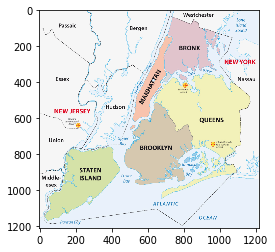

In [237]:
im = plt.imread("map_of_nyc.png")
implot = plt.imshow(im)

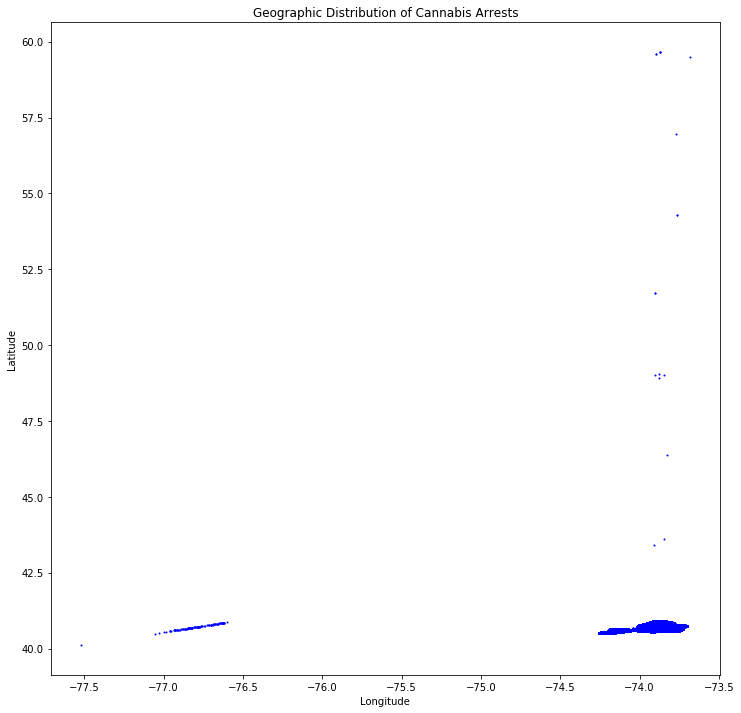

In [238]:
ax = nyc_non_cann.plot(x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='b', s=1, title='Geographic Distribution of Cannabis Arrests')
plt.show()

There looks to be several outlier cases with Latitudes and Longitudes outside of the boundaries of New York City that need to be removed before a proper scatterplot can be run. The boundaries of New York City range from 40.495992 through 40.915568 Latitude North and -74.257159 through -73.699215 Longitude West (https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/nybb_metadata.pdf?ver=19d). For situations where a significant proportion of cases are geographic outliers, their latitude/longitude values would be trimmed to the maximum or minimum point of the range, whichever is nearest. However, because of the vanishingly small proportion of outliers (129 out of 6,238,620 cases), removing these cases will not bias the results. 


The outliers are identified by first defining a Boolean mask Series called 'lat_lon_keeper' for cases where the Latitude and Longitude are within this range. Next, a new integer type feature named 'lat_lon_keeper' is created in the 'nyc_non_cann' DataFrame by assigning the Boolean mask Series 'lat_lon_keeper' to it, assigning values of '1' for the keepers and '0' for the outliers.

In [239]:
nyc_non_cann.shape

(6238620, 72)

In [240]:
lat_lon_keeper = (nyc_non_cann.Latitude >= 40.495992) & (nyc_non_cann.Latitude <= 40.915568) & (nyc_non_cann.Longitude >= -74.257159) & (nyc_non_cann.Longitude <= -73.699215)

In [241]:
nyc_non_cann['lat_lon_keeper'] = lat_lon_keeper.astype(int)

In [242]:
nyc_non_cann.lat_lon_keeper.value_counts()

1    6238491
0        129
Name: lat_lon_keeper, dtype: int64

The outliers are then dropped from the DataFrame, and the value counts for the 'lat_lon_keeper' feature are called to verify that only cases within the defined latitude/longitude boundaries of New York City are kept.

In [243]:
nyc_non_cann.drop(nyc_non_cann[nyc_non_cann.lat_lon_keeper == 0].index, inplace=True)

In [244]:
nyc_non_cann.lat_lon_keeper.value_counts()

1    6238491
Name: lat_lon_keeper, dtype: int64

The 'lat_lon_keeper' column is dropped from the DataFrame, as it is no longer needed.

In [245]:
nyc_non_cann = nyc_non_cann.drop(columns = 'lat_lon_keeper')

Now that the geographic outliers have been removed, one can see the familiar shape of NYC emerge. 

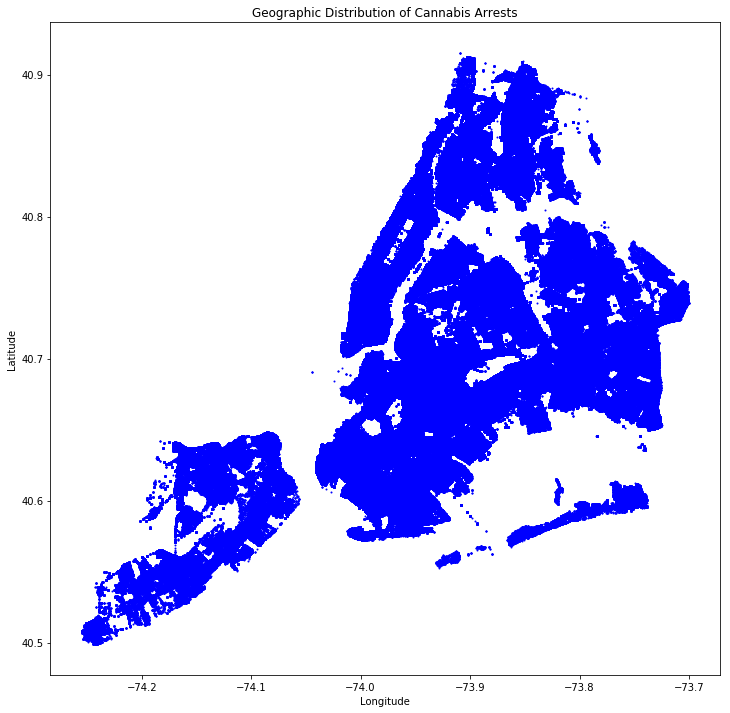

In [246]:
ax = nyc_non_cann.plot(x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='b', s=1, title='Geographic Distribution of Cannabis Arrests')

## Patrol Borough

The next native feature that needs to be examined for outliers is 'PATROL_BORO', the NYPD Patrol Borough that the crime occurred in (if known). These patrol boroughs break the traditional five NYC boroughs into smaller geographic areas. The features' value counts are called, and the values are checked against the list of NYC patrol boroughs publicly available on https://www1.nyc.gov/site/nypd/stats/crime-statistics/borough-and-precinct-crime-stats.page.

In [247]:
nyc_non_cann['PATROL_BORO'].value_counts()

PATROL BORO BRONX            1314994
PATROL BORO BKLYN SOUTH       937655
PATROL BORO BKLYN NORTH       916078
PATROL BORO MAN SOUTH         767281
PATROL BORO MAN NORTH         735291
PATROL BORO QUEENS NORTH      652570
PATROL BORO QUEENS SOUTH      614873
PATROL BORO STATEN ISLAND     299672
unknown                           77
Name: PATROL_BORO, dtype: int64

After reviewing, there are no outlying or erroneous values that need to be dropped.

## MTA Transit Stations

The next native feature that needs to be examined for outliers is 'STATION_NAME', the MTA transit station that the crime occurred in (if any). The features' value counts are called, and the values are checked against the csv file of MTA transit stations publicly available on https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv?accessType=DOWNLOAD.

In [248]:
nyc_non_cann['STATION_NAME'].value_counts()

not_transit_related               6098307
125 STREET                           7287
14 STREET                            4006
34 ST.-PENN STATION                  3373
42 ST.-PORT AUTHORITY BUS TERM       3081
116 STREET                           3050
42 ST.-GRAND CENTRAL                 2820
42 ST.-TIMES SQUARE                  2680
CANAL STREET                         2169
59 ST.-COLUMBUS CIRCLE               1876
UTICA AVE.-CROWN HEIGHTS             1801
86 STREET                            1611
59 STREET                            1509
3 AVENUE-149 STREET                  1470
JAY STREET-BOROUGH HALL              1388
96 STREET                            1354
NOSTRAND AVENUE                      1325
PARSONS/ARCHER-JAMAICA CENTER        1314
FORDHAM ROAD                         1313
145 STREET                           1291
23 STREET                            1254
161 ST.-YANKEE STADIUM               1223
34 ST.-HERALD SQ.                    1208
W. 4 STREET                       

After reviewing, there are several station names not in the '1st_Capstone_Data_Cleaning_cannabis_Daniel_Loew' notebook that don't show up clearly in the online source above. However, they are easily discoverable via a Google search. These station names are as follows:

23 STREET-ELY AVENUE


45 ROAD-COURT HOUSE SQUARE


LAWRENCE STREET


Therefore, no outlying or erroneous values need to be dropped.

# Creation of Continuous Geographic Features

The following section encodes the distance of each cannabis crime from prominent NYC landmarks into continuous data features. All latitudes and longitudes were found from Google searches. Driving/walking/biking distances, or 'L1' features, are computed. Shortest distances ("as the crow flies"), or 'L2' features, are also computed. This is done by creating a DataFrame with latitudes and longitudes for each NYC landmark, which is transposed for ease of use in two 'for' loops executed below. These 'for' loops create individual features storing the distance of each crime from each of the landmarks, both for 'L1' and 'L2' distances. The longitude is programmatically assigned a negative value because NYC has negative longitude as it is west of the Prime Meridian.

The series of landmarks, and their respective abbreviations, are as follows:

World Trade Center - wtc


New York Stock Exchange - nyse


Brooklyn Bridge - bk_bridge


City Hall - city_hall


Manhattan Bridge - manh_bridge


Williamsburg Bridge - will_bridge


Washington Square Park - wash_sq_park


Union Square - union_sq


Penn Station - penn_station


Times Square - times_sq


Rockefeller Center - rock_center


Empire State Building - empire_st_bldg


Lincoln Center - lincoln_ctr


Central Park - central_pk


Apollo Theatre - apollo_th


Yankee Stadium - yankee_stad


NY Mets Stadium - mets_stad


Center of Queens Borough - queens


Prospect Park - prospect_pk


Downtown Brooklyn - downtown_bk


Staten Island Ferry - si_ferry


NY Port Authority Bus Station - port_authority


New York Police Department Headquarters - nypd_hq


Metropolitan Detention Center - mdc


Riker's Island - rikers


New York Supreme Court - nysc

In [249]:
lat_long = pd.DataFrame(dict(wtc = dict(lat= 40.7127, lon= 74.0134), nyse = dict(lat= 40.706877, lon= 74.011265), 
                        bk_bridge = dict(lat= 40.7061, lon= 73.9969), city_hall = dict(lat= 40.7128, lon= 74.0061), 
                        manh_bridge = dict(lat= 40.7075, lon= 73.9908), will_bridge = dict(lat= 40.7136, lon= 73.9724),  
                        wash_sq_park = dict(lat= 40.7308, lon= 73.9973), union_sq = dict(lat= 40.7359, lon= 73.9911), 
                        penn_station = dict(lat= 40.7506, lon= 73.9935), times_sq = dict(lat= 40.7580, lon= 73.9855), 
                        rock_center = dict(lat= 40.7587, lon= 73.9787), empire_st_bldg = dict(lat= 40.7484, lon= 73.9857), 
                        lincoln_ctr = dict(lat= 40.7725, lon= 73.9835), central_pk = dict(lat= 40.7829, lon= 73.9654), 
                        apollo_th = dict(lat= 40.8100, lon= 73.9501), yankee_stad = dict(lat= 40.8296, lon= 73.9262), 
                        mets_stad = dict(lat= 40.7571, lon= 73.8458), queens = dict(lat= 40.7282, lon= 73.7949), 
                        prospect_pk = dict(lat= 40.6602, lon= 73.9690), downtown_bk = dict(lat= 40.6961, lon= 73.9845),
                        si_ferry = dict(lat= 40.671946, lon= 74.042495), port_authority = dict(lat= 40.7569, lon= 73.9903), 
                        nypd_hq = dict(lat= 40.7121, lon= 74.0019), mdc = dict(lat= 40.6599, lon= 74.0038), 
                        rikers = dict(lat= 40.7931, lon= 73.8860), nysc = dict(lat= 40.7144, lon= 74.0020)))
lat_long = lat_long.T
lat_long['lon'] = - lat_long['lon']
lat_long

,lat,lon
wtc,40.712700,-74.013400
nyse,40.706877,-74.011265
bk_bridge,40.706100,-73.996900
city_hall,40.712800,-74.006100
manh_bridge,40.707500,-73.990800
will_bridge,40.713600,-73.972400
wash_sq_park,40.730800,-73.997300
union_sq,40.735900,-73.991100
penn_station,40.750600,-73.993500
times_sq,40.758000,-73.985500


In [250]:
for name in lat_long.index:
    nyc_non_cann[name+'_l1'] = abs(nyc_non_cann.Latitude - lat_long['lat'][name]) + abs(nyc_non_cann.Longitude - lat_long['lon'][name])

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new continuous geographic L1 features were created.

In [251]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.186276,0.178318,0.163176,0.179076,0.158476,0.146176,0.188276,0.187176,0.204276,0.203676,0.197576,0.194276,0.216176,0.208476,0.220276,0.215976,0.116231,0.138231,0.103869,0.140776,0.174617,0.207376,0.174176,0.138969,0.139276,0.176576


In [252]:
for name in lat_long.index:
    nyc_non_cann[name+'_l2'] = ((nyc_non_cann.Latitude - lat_long['lat'][name])**2 + (nyc_non_cann.Longitude - lat_long['lon'][name])**2)**0.5

The first row's values of the 'nyc_non_cann' DataFrame are called to verify that all of the new continuous geographic L2 features were created.

In [253]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2
0,577055921,12/31/2018,19:00:00,75,12/31/2018,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - PUBLIC HOUSING,N.Y. HOUSING POLICE,unknown,EAST NEW YORK CITY LINE,1019655.0,182468.0,<18,BLACK,F,not_transit_related,40.667447,-73.872377,"(40.667446665, -73.872377258)",PATROL BORO BKLYN NORTH,not_transit_related,18-24,BLACK,M,2018-12-31 19:00:00,0,2018.0,12.0,31.0,19.0,0.0,0.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.186276,0.178318,0.163176,0.179076,0.158476,0.146176,0.188276,0.187176,0.204276,0.203676,0.197576,0.194276,0.216176,0.208476,0.220276,0.215976,0.116231,0.138231,0.103869,0.140776,0.174617,0.207376,0.174176,0.138969,0.139276,0.176576,0.148106,0.144376,0.130384,0.141204,0.125013,0.110158,0.140069,0.137044,0.146919,0.144902,0.140113,0.139268,0.15292,0.148266,0.162365,0.170853,0.09351,0.098457,0.096894,0.115726,0.170177,0.148012,0.137004,0.131639,0.12639,0.137865


# Recoding and Cleaning Age, Race, and Sex Features

The next section recodes unclear values to 'unknown' for the suspect and victim age group, race, and sex features. First, the value counts are run for each feature. Then, a cleaned version of the feature is created by mapping unusual values to 'unknown'. And finally value counts are called on the cleaned version of the feature to ensure all unusual values have been mapped to 'unknown'.

In [254]:
nyc_non_cann['SUSP_AGE_GROUP'].value_counts()

unknown    4373486
25-44       778060
UNKNOWN     393912
18-24       302889
45-64       279980
<18          87497
65+          22509
2018            10
2017             8
2016             8
-969             4
926              4
940              4
-972             4
-2               4
-974             3
1017             3
2015             3
-979             3
931              3
935              3
1018             3
937              2
952              2
936              2
-978             2
-960             2
-975             2
-948             2
-962             2
1016             2
-976             2
-1               2
945              2
1007             2
928              2
922              2
-971             2
-970             2
809              1
-965             1
324              1
946              1
-973             1
1053             1
914              1
-939             1
810              1
-80              1
999              1
808              1
-72              1
-985        

In [255]:
nyc_non_cann['SUSP_AGE_GROUP_cleaned'] = nyc_non_cann['SUSP_AGE_GROUP'].map({'<18': '<18', '18-24': '18-24', 
                                                                     '25-44': '25-44', '45-64': '45-64', 
                                                                     '65+': '65+', 'unknown': 'unknown', 
                                                                     'UNKNOWN': 'unknown', '2018': 'unknown', '2016': 'unknown', '2017': 'unknown', '-969': 'unknown', '-2': 'unknown', '940': 'unknown', '-972': 'unknown', '926': 'unknown', '-974': 'unknown', '1018': 'unknown', '935': 'unknown', '931': 'unknown', '1017': 'unknown', '-979': 'unknown', '2015': 'unknown', '-978': 'unknown', '-960': 'unknown', '-970': 'unknown', '937': 'unknown', '936': 'unknown', '945': 'unknown', '928': 'unknown', '-976': 'unknown', '1007': 'unknown', '-948': 'unknown', '1016': 'unknown', '-1': 'unknown', '-975': 'unknown', '-971': 'unknown', '-962': 'unknown', '922': 'unknown', '952': 'unknown', '-963': 'unknown', '933': 'unknown', '920': 'unknown', '1014': 'unknown', '1932': 'unknown', '809': 'unknown', '1967': 'unknown', '966': 'unknown', '925': 'unknown', '-935': 'unknown', '954': 'unknown', '914': 'unknown', '915': 'unknown', '324': 'unknown', '327': 'unknown', '944': 'unknown', '708': 'unknown', '808': 'unknown', '-941': 'unknown', '955': 'unknown', '-49': 'unknown', '709': 'unknown', '-985': 'unknown', '-54': 'unknown', '934': 'unknown', '814': 'unknown', '1053': 'unknown', '-968': 'unknown', '-953': 'unknown', '-939': 'unknown', '946': 'unknown', '924': 'unknown', '-83': 'unknown', '938': 'unknown', '972': 'unknown', '948': 'unknown', '-42': 'unknown', '949': 'unknown', '-973': 'unknown', '-63': 'unknown', '810': 'unknown', '-981': 'unknown', '-80': 'unknown', '927': 'unknown', '-955': 'unknown', '-65': 'unknown', '-67': 'unknown', '-980': 'unknown', '942': 'unknown', '923': 'unknown', '309': 'unknown', '1933': 'unknown', '999': 'unknown', '-72': 'unknown', '711': 'unknown', '-965': 'unknown', '1012': 'unknown'})

In [256]:
nyc_non_cann['SUSP_AGE_GROUP_cleaned'].value_counts()

unknown    4767556
25-44       778060
18-24       302889
45-64       279980
<18          87497
65+          22509
Name: SUSP_AGE_GROUP_cleaned, dtype: int64

In [257]:
nyc_non_cann['SUSP_RACE'].value_counts()

unknown                           3014327
BLACK                             1200023
UNKNOWN                            843107
WHITE HISPANIC                     545425
WHITE                              361277
BLACK HISPANIC                     163399
ASIAN / PACIFIC ISLANDER           100862
AMERICAN INDIAN/ALASKAN NATIVE      10061
OTHER                                  10
Name: SUSP_RACE, dtype: int64

In [258]:
nyc_non_cann['SUSP_RACE_cleaned'] = nyc_non_cann['SUSP_RACE'].map({'BLACK': 'BLACK', 'WHITE HISPANIC': 'WHITE HISPANIC', 
                                              'BLACK HISPANIC': 'BLACK HISPANIC', 'WHITE': 'WHITE',
                                              'ASIAN / PACIFIC ISLANDER': 'ASIAN / PACIFIC ISLANDER', 
                                              'unknown': 'unknown','UNKNOWN': 'unknown', 
                                              'AMERICAN INDIAN/ALASKAN NATIVE': 'AMERICAN INDIAN/ALASKAN NATIVE', 'OTHER': 'unknown'})

After discovering that only 15.8% of cannabis crimes have their suspect's race reported, it is warranted to look at what percentage of non-cannabis crimes have their suspect's race reported. As can be seen below, 38.2% of non-cannabis crimes have their suspect's race reported. This is a large difference in the reporting of suspect race, and warrants a hypothesis test in a later section of this project to see if the difference is due to random chance.

In [259]:
round(nyc_non_cann['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100

unknown                           61.8
BLACK                             19.2
WHITE HISPANIC                     8.7
WHITE                              5.8
BLACK HISPANIC                     2.6
ASIAN / PACIFIC ISLANDER           1.6
AMERICAN INDIAN/ALASKAN NATIVE     0.2
Name: SUSP_RACE_cleaned, dtype: float64

In [260]:
nyc_non_cann['SUSP_SEX'].value_counts()

unknown    3145791
M          1951573
F           634928
U           506199
Name: SUSP_SEX, dtype: int64

In [261]:
nyc_non_cann['SUSP_SEX_cleaned'] = nyc_non_cann['SUSP_SEX'].map({'M': 'M', 'F': 'F', 'U': 'unknown', 
                                                         'unknown': 'unknown'})

In [262]:
nyc_non_cann['SUSP_SEX_cleaned'].value_counts()

unknown    3651990
M          1951573
F           634928
Name: SUSP_SEX_cleaned, dtype: int64

In [263]:
nyc_non_cann['VIC_AGE_GROUP'].value_counts()

25-44      2095125
unknown    1442128
45-64      1089778
18-24       662456
UNKNOWN     426297
<18         303345
65+         218977
929             10
937              8
-1               8
938              8
946              8
922              7
936              7
-962             6
-2               5
808              5
927              5
-970             5
947              4
-978             4
931              4
948              4
930              4
-964             4
924              4
-973             4
812              4
942              4
962              4
-974             4
-972             4
932              4
934              3
940              3
-955             3
-950             3
958              3
-72              3
711              3
926              3
951              3
954              3
949              3
970              3
809              3
-32              3
950              3
-966             3
928              3
-956             3
-48              3
-980        

In [264]:
nyc_non_cann['VIC_AGE_GROUP_cleaned'] = nyc_non_cann['VIC_AGE_GROUP'].map({'UNKNOWN': 'unknown', 'unknown': 'unknown', 
                                                                   '<18': '<18', '18-24': '18-24', 
                                                                   '25-44': '25-44', '45-64': '45-64', 
                                                                   '65+': '65+', '929': 'unknown', '946': 'unknown', '938': 'unknown', '-1': 'unknown', '937': 'unknown', '922': 'unknown', '936': 'unknown', '-962': 'unknown', '927': 'unknown', '-970': 'unknown', '-2': 'unknown', '808': 'unknown', '924': 'unknown', '-974': 'unknown', '947': 'unknown', '812': 'unknown', '962': 'unknown', '-973': 'unknown', '932': 'unknown', '-964': 'unknown', '942': 'unknown', '931': 'unknown', '-972': 'unknown', '930': 'unknown', '-978': 'unknown', '948': 'unknown', '949': 'unknown', '-955': 'unknown', '934': 'unknown', '-966': 'unknown', '940': 'unknown', '958': 'unknown', '926': 'unknown', '-48': 'unknown', '939': 'unknown', '950': 'unknown', '933': 'unknown', '810': 'unknown', '-956': 'unknown', '809': 'unknown', '-72': 'unknown', '951': 'unknown', '960': 'unknown', '954': 'unknown', '970': 'unknown', '-980': 'unknown', '-32': 'unknown', '-950': 'unknown', '928': 'unknown', '711': 'unknown', '-948': 'unknown', '955': 'unknown', '925': 'unknown', '151': 'unknown', '913': 'unknown', '-940': 'unknown', '-957': 'unknown', '941': 'unknown', '-984': 'unknown', '-60': 'unknown', '964': 'unknown', '-3': 'unknown', '-934': 'unknown', '-959': 'unknown', '944': 'unknown', '914': 'unknown', '-975': 'unknown', '-61': 'unknown', '-982': 'unknown', '-976': 'unknown', '-73': 'unknown', '943': 'unknown', '-40': 'unknown', '959': 'unknown', '811': 'unknown', '945': 'unknown', '953': 'unknown', '-49': 'unknown', '923': 'unknown', '956': 'unknown', '957': 'unknown', '-954': 'unknown', '935': 'unknown', '-952': 'unknown', '-958': 'unknown', '-971': 'unknown', '-943': 'unknown', '-55': 'unknown', '508': 'unknown', '-939': 'unknown', '980': 'unknown', '-63': 'unknown', '918': 'unknown', '-968': 'unknown', '160': 'unknown', '1014': 'unknown', '172': 'unknown', '901': 'unknown', '999': 'unknown', '-961': 'unknown', '509': 'unknown', '158': 'unknown', '-953': 'unknown', '917': 'unknown', '-929': 'unknown', '910': 'unknown', '-47': 'unknown', '895': 'unknown', '965': 'unknown', '-967': 'unknown', '-945': 'unknown', '981': 'unknown', '-7': 'unknown', '-70': 'unknown', '-937': 'unknown', '972': 'unknown', '977': 'unknown', '-43': 'unknown', '-85': 'unknown', '-923': 'unknown', '188': 'unknown', '912': 'unknown', '324': 'unknown', '214': 'unknown', '838': 'unknown', '1017': 'unknown', '-938': 'unknown', '-4': 'unknown', '359': 'unknown', '952': 'unknown', '-915': 'unknown', '979': 'unknown', '738': 'unknown', '334': 'unknown', '342': 'unknown', '-946': 'unknown', '343': 'unknown', '-59': 'unknown', '-81': 'unknown', '-884': 'unknown', '1012': 'unknown', '-936': 'unknown', '-969': 'unknown', '507': 'unknown', '-52': 'unknown', '-981': 'unknown', '-37': 'unknown', '154': 'unknown', '260': 'unknown', '-51': 'unknown', '-5': 'unknown', '309': 'unknown', '-983': 'unknown', '707': 'unknown', '-932': 'unknown', '-39': 'unknown', '-67': 'unknown', '-902': 'unknown', '-75': 'unknown', '-76': 'unknown', '623': 'unknown', '806': 'unknown', '-78': 'unknown', '961': 'unknown', '-53': 'unknown', '340': 'unknown', '-947': 'unknown', '-36': 'unknown', '920': 'unknown', '-931': 'unknown', '-65': 'unknown', '908': 'unknown', '185': 'unknown', '-942': 'unknown', '709': 'unknown', '-985': 'unknown', '-45': 'unknown', '152': 'unknown', '909': 'unknown', '311': 'unknown', '911': 'unknown'})

In [265]:
nyc_non_cann['VIC_AGE_GROUP_cleaned'].value_counts()

25-44      2095125
unknown    1868810
45-64      1089778
18-24       662456
<18         303345
65+         218977
Name: VIC_AGE_GROUP_cleaned, dtype: int64

In [266]:
nyc_non_cann['VIC_RACE'].value_counts()

UNKNOWN                           1957900
BLACK                             1531147
WHITE                             1121326
WHITE HISPANIC                    1028128
ASIAN / PACIFIC ISLANDER           357932
BLACK HISPANIC                     212514
AMERICAN INDIAN/ALASKAN NATIVE      29264
unknown                               251
OTHER                                  29
Name: VIC_RACE, dtype: int64

In [267]:
nyc_non_cann['VIC_RACE_cleaned'] = nyc_non_cann['VIC_RACE'].map({'UNKNOWN': 'unknown', 'BLACK': 'BLACK', 'WHITE HISPANIC': 'WHITE HISPANIC',
                                            'WHITE': 'WHITE', 'BLACK HISPANIC': 'BLACK HISPANIC', 
                                            'ASIAN / PACIFIC ISLANDER': 'ASIAN / PACIFIC ISLANDER', 
                                            'AMERICAN INDIAN/ALASKAN NATIVE': 'AMERICAN INDIAN/ALASKAN NATIVE', 
                                            'unknown': 'unknown', 'OTHER': 'unknown'})

In [268]:
nyc_non_cann['VIC_RACE_cleaned'].value_counts()

unknown                           1958180
BLACK                             1531147
WHITE                             1121326
WHITE HISPANIC                    1028128
ASIAN / PACIFIC ISLANDER           357932
BLACK HISPANIC                     212514
AMERICAN INDIAN/ALASKAN NATIVE      29264
Name: VIC_RACE_cleaned, dtype: int64

In [269]:
nyc_non_cann['VIC_SEX'].value_counts()

F          2521114
M          2103075
E           844866
D           769186
unknown        250
Name: VIC_SEX, dtype: int64

In [270]:
nyc_non_cann['VIC_SEX_cleaned'] = nyc_non_cann['VIC_SEX'].map({'E': 'unknown', 'M': 'M', 'D': 'unknown', 'F': 'F', 
                                                      'unknown': 'unknown'})

In [271]:
nyc_non_cann['VIC_SEX_cleaned'].value_counts()

F          2521114
M          2103075
unknown    1614302
Name: VIC_SEX_cleaned, dtype: int64

The old uncleaned suspect and victim age group, race, and sex features are dropped from the DataFrame as they are not needed.

In [272]:
nyc_non_cann = nyc_non_cann.drop(columns=['SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'])

# Sampling the DataFrame

The hypothesis testing done in the Statistical Data Analysis notebook requires a sample of all NYC crimes. Now that the non-cannabis crime data has been cleaned, a 10% sample is taken and exported to a .csv file. The same was done in the cannabis crime data cleaning notebook, and the two sample DataFrames will be concatenated in the Statistical Data Analysis notebook. After the sample is taken and the .csv file is exported, the nyc_non_cann_HT_sample DataFrame is deleted to free up computational memory.

In [273]:
nyc_non_cann.shape

(6238491, 124)

In [274]:
nyc_non_cann_HT_sample = nyc_non_cann.sample(n=623849, random_state=42, axis=0)

In [275]:
nyc_non_cann_HT_sample.to_csv('nyc_non_cann_HT_sample.csv')

In [276]:
del nyc_non_cann_HT_sample

The .get_dummies() method below will convert categorical features into binary features for machine learning classification purposes, but the categorical features will be lost with this method. For ease of use in doing any necessary visual and statistical EDA, the version of the DataFrame with categorical features intact are exported below after sampling is done. Duplicate rows are first looked for to make sure no duplication accidentally occurred above, as duplicate rows can be a source of machine learning leakage.

In [277]:
nyc_non_cann.shape

(6238491, 124)

In [278]:
nyc_non_cann = nyc_non_cann.drop_duplicates()
nyc_non_cann.shape

(6238491, 124)

There are no duplicate rows.

The next code cell samples a DataFrame of non-cannabis crimes with size equal to that of the cannabis crimes DataFrame (n=220,304). The .shape attribute is called on this sample DataFrame to confirm the sample size is correct.

In [279]:
nyc_non_cann_sample = nyc_non_cann.sample(n=220304, random_state=42, axis=0)

In [280]:
nyc_non_cann_sample.shape

(220304, 124)

Next, PD_CD and LAW_CAT_CD distributions of the full universe and the sample of non-cannabis crimes are visually compared. This is done to ensure that certain crimes are not randomly over-represented in the sample, as that could result in invalid machine learning classification models. The values of the universe and the sample are remarkably comparable.

In [281]:
nyc_non_cann.PD_CD.value_counts(normalize=True)

101.0    9.016075e-02
638.0    8.196934e-02
639.0    5.441893e-02
333.0    4.833461e-02
637.0    4.677942e-02
338.0    4.468196e-02
254.0    3.696359e-02
321.0    3.410616e-02
109.0    3.213790e-02
259.0    2.934331e-02
438.0    2.083645e-02
258.0    1.940758e-02
511.0    1.884318e-02
397.0    1.739796e-02
441.0    1.682715e-02
339.0    1.598463e-02
221.0    1.493598e-02
113.0    1.463607e-02
905.0    1.419606e-02
782.0    1.362285e-02
198.0    1.242720e-02
205.0    1.091161e-02
739.0    1.034433e-02
421.0    1.008096e-02
916.0    9.155099e-03
729.0    8.790587e-03
793.0    8.284375e-03
419.0    8.199900e-03
223.0    7.888927e-03
405.0    7.580038e-03
267.0    7.555353e-03
349.0    7.533873e-03
269.0    7.004579e-03
357.0    6.490191e-03
749.0    6.467910e-03
343.0    6.178417e-03
175.0    5.692563e-03
439.0    5.615300e-03
386.0    5.334944e-03
750.0    5.242293e-03
759.0    4.859348e-03
213.0    4.784330e-03
503.0    4.052743e-03
106.0    3.673164e-03
490.0    3.647837e-03
117.0    3

In [282]:
nyc_non_cann_sample.PD_CD.value_counts(normalize=True)

101.0    0.090434
638.0    0.082137
639.0    0.053630
333.0    0.048265
637.0    0.046186
338.0    0.044134
254.0    0.036786
321.0    0.033781
109.0    0.031820
259.0    0.029441
438.0    0.020821
258.0    0.019423
511.0    0.018733
397.0    0.018034
441.0    0.016768
339.0    0.016486
221.0    0.015188
113.0    0.014362
905.0    0.014335
782.0    0.013658
198.0    0.012505
205.0    0.010885
739.0    0.010236
421.0    0.010141
916.0    0.009269
729.0    0.009133
793.0    0.008670
419.0    0.008139
223.0    0.008066
405.0    0.007408
349.0    0.007399
267.0    0.007304
269.0    0.007054
749.0    0.006573
357.0    0.006518
343.0    0.006282
175.0    0.005601
386.0    0.005560
439.0    0.005556
750.0    0.005338
759.0    0.005075
213.0    0.004666
503.0    0.003890
490.0    0.003845
718.0    0.003749
106.0    0.003677
117.0    0.003509
705.0    0.003291
748.0    0.003246
922.0    0.003223
105.0    0.003155
433.0    0.003141
388.0    0.003137
462.0    0.003127
114.0    0.003118
403.0    0

In [283]:
nyc_non_cann.LAW_CAT_CD.value_counts(normalize=True)

MISDEMEANOR    0.554283
FELONY         0.315876
VIOLATION      0.129841
Name: LAW_CAT_CD, dtype: float64

In [284]:
nyc_non_cann_sample.LAW_CAT_CD.value_counts(normalize=True)

MISDEMEANOR    0.553326
FELONY         0.317257
VIOLATION      0.129417
Name: LAW_CAT_CD, dtype: float64

Because the nyc_non_cann DataFrame is no longer needed in this notebook, it is deleted in order to free up computational resources. 

In [285]:
del nyc_non_cann

## Creating a feature for distance to closest subway station entrance

Subway station entrances can be places where people sell, purchase, consume, and get cannabis delivered in New York City, and the Open NY project has latitudes and longitudes of all NYC subway stations and their entrances (https://data.ny.gov/widgets/i9wp-a4ja). A feature is created below that determines the distance to the closest subway station for each cannabis crime.

The .csv file of all NYC Transit Subway entrances and exits is loaded and assigned to a DataFrame named 'subway_lat_lon'. Basic descriptive methods are called to inspect it.

In [286]:
subway_lat_lon = pd.read_csv("NYC_Transit_Subway_Entrance_And_Exit_Data.csv")

In [287]:
subway_lat_lon.head()

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,Route6,Route7,Route8,Route9,Route10,Route11,Entrance Type,Entry,Exit Only,Vending,Staffing,Staff Hours,ADA,ADA Notes,Free Crossover,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,NONE,NaN,False,NaN,False,4th Ave,25th St,SW,40.660489,-73.998220,"(40.660397, -73.998091)","(40.660489, -73.99822)"
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,False,4th Ave,25th St,SE,40.660323,-73.997952,"(40.660397, -73.998091)","(40.660323, -73.997952)"
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NW,40.654676,-74.004306,"(40.655144, -74.003549)","(40.654676, -74.004306)"
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NE,40.654365,-74.004113,"(40.655144, -74.003549)","(40.654365, -74.004113)"
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stair,YES,NaN,YES,FULL,NaN,False,NaN,True,4th Ave,36th St,NW,40.654490,-74.004499,"(40.655144, -74.003549)","(40.65449, -74.004499)"


In [288]:
len(subway_lat_lon)

1868

In [289]:
subway_lat_lon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868 entries, 0 to 1867
Data columns (total 32 columns):
Division              1868 non-null object
Line                  1868 non-null object
Station Name          1868 non-null object
Station Latitude      1868 non-null float64
Station Longitude     1868 non-null float64
Route1                1868 non-null object
Route2                1020 non-null object
Route3                494 non-null object
Route4                321 non-null object
Route5                238 non-null object
Route6                127 non-null object
Route7                80 non-null object
Route8                48 non-null float64
Route9                28 non-null float64
Route10               23 non-null float64
Route11               23 non-null float64
Entrance Type         1868 non-null object
Entry                 1868 non-null object
Exit Only             56 non-null object
Vending               1868 non-null object
Staffing              1868 non-null object


The presence of duplicate cases is checked for, using .drop_duplicates(). There are none, as the shape of the 'subway_lat_lon' DataFrame is the same before and after running the .drop_duplicates() method.

In [290]:
subway_lat_lon = subway_lat_lon.drop_duplicates()
subway_lat_lon.shape

(1868, 32)

The only columns from the 'subway_lat_lon' DataFrame that are needed to create the new 'closest subway station' feature are 'Station Name', 'Entrance Latitude', 'Entrance Longitude', and 'Corner'. Null values within these columns could prevent the proper creation of the new 'closest subway station' feature, so they are checked for within the 'subway_lat_lon' DataFrame.

In [291]:
sll_nulls = list(subway_lat_lon.columns[(subway_lat_lon.isnull().sum()>0) | (subway_lat_lon.isna().sum()>0)])
sll_nulls

['Route2',
 'Route3',
 'Route4',
 'Route5',
 'Route6',
 'Route7',
 'Route8',
 'Route9',
 'Route10',
 'Route11',
 'Exit Only',
 'Staff Hours',
 'ADA Notes',
 'North South Street',
 'East West Street',
 'Corner']

'Corner' is the only column of interest that has null values. The null values are filled with the value 'unknown'.

In [292]:
fill_na_corner = ['Corner']

In [293]:
subway_lat_lon[fill_na_corner] = subway_lat_lon[fill_na_corner].fillna(value='unknown', axis=1)

The presence of null values is checked for again. 'Corner' no longer shows up in the list of columns with null values.

In [294]:
sll_nulls = list(subway_lat_lon.columns[(subway_lat_lon.isnull().sum()>0) | (subway_lat_lon.isna().sum()>0)])
sll_nulls

['Route2',
 'Route3',
 'Route4',
 'Route5',
 'Route6',
 'Route7',
 'Route8',
 'Route9',
 'Route10',
 'Route11',
 'Exit Only',
 'Staff Hours',
 'ADA Notes',
 'North South Street',
 'East West Street']

For the greatest level of specificity, the 'Station Name' and 'Corner' features are combined to create the 'Station_Corner' feature.

In [295]:
subway_lat_lon['Station_corner'] = subway_lat_lon['Station Name'] + ' ' + subway_lat_lon['Corner']
subway_lat_lon['Station_corner'].head()

0    25th St SW
1    25th St SE
2    36th St NW
3    36th St NE
4    36th St NW
Name: Station_corner, dtype: object

A simpler DataFrame is subsetted from the 'subway_lat_lon' DataFrame with only the columns that are needed to create the new 'closest subway station' feature: 'Station_corner', 'Entrance Latitude', and 'Entrance Longitude'.

In [296]:
sll_simple = subway_lat_lon[['Station_corner', 'Entrance Latitude', 'Entrance Longitude']]
sll_simple.head()

,Station_corner,Entrance Latitude,Entrance Longitude
0,25th St SW,40.660489,-73.998220
1,25th St SE,40.660323,-73.997952
2,36th St NW,40.654676,-74.004306
3,36th St NE,40.654365,-74.004113
4,36th St NW,40.654490,-74.004499


'Type' is called on 'sll_simple' to verify its DataFrame format.

In [297]:
type(sll_simple)

pandas.core.frame.DataFrame

The subsetted DataFrame's shape is called again, and the presence of duplicate rows is checked for with the .drop_duplicates() method and the re-calling of the DataFrame's shape. 11 duplicate rows are found and removed.

In [298]:
sll_simple.shape

(1868, 3)

In [299]:
sll_simple = sll_simple.drop_duplicates()
sll_simple.shape

(1857, 3)

The complete lack of null values is verified with the .info() method and the creation of the 'slls_nulls' object, which is returned as an empty list.

In [300]:
sll_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1857 entries, 0 to 1867
Data columns (total 3 columns):
Station_corner        1857 non-null object
Entrance Latitude     1857 non-null float64
Entrance Longitude    1857 non-null float64
dtypes: float64(2), object(1)
memory usage: 58.0+ KB


In [301]:
slls_nulls = list(sll_simple.columns[(sll_simple.isnull().sum()>0) | (sll_simple.isna().sum()>0)])
slls_nulls

[]

Driving/walking/biking distance, or 'L1', features, are computed for each subway station for each row. Shortest distance ("as the crow flies"), or 'L2', features are also computed. This is done by creating a DataFrame named 'subways' with latitudes and longitudes for each subway station/corner, which is transposed for ease of use in two 'for' loops executed below. These 'for' loops create individual features storing the distance of each crime from each of the subway station/corners, both for 'L1' and 'L2' distances.

In [302]:
subways = pd.DataFrame({item['Station_corner']: {'entrance_latitude': item['Entrance Latitude'], 
                                               'entrance_longitude': item['Entrance Longitude']} 
                      for item in sll_simple.to_dict(orient='records')})
subways = subways.T
subways.head()

,entrance_latitude,entrance_longitude
25th St SW,40.660489,-73.998220
25th St SE,40.660323,-73.997952
36th St NW,40.654490,-74.004499
36th St NE,40.752232,-73.928775
45th St NE,40.649265,-74.009457


The type of the 'subways' object is verified as a DataFrame, and the .info() method is called to verify the number of rows and that there are no null values. 

In [303]:
type(subways)

pandas.core.frame.DataFrame

In [304]:
subways.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 25th St SW to Wakefield-241st St NE
Data columns (total 2 columns):
entrance_latitude     1008 non-null float64
entrance_longitude    1008 non-null float64
dtypes: float64(2)
memory usage: 23.6+ KB


The length of the 'subways' DataFrame is smaller than that of the 'sll_simple' DataFrame. That is because there is only one row in the 'subways' DataFrame for each value of 'Station_corner'. In the original .csv file of subway stations, it is seen in the next cell that is often more than one row for each station/corner. This is because there was often more than one row needed to store other data values beyond the columns needed for this notebook's purposes.

In [305]:
subway_lat_lon['Station_corner'].value_counts().head(10)

23rd St NE             12
34th St NE             11
34th St NW             11
59th St NW             11
23rd St NW             10
23rd St SE             10
14th St NE              9
14th St NW              9
34th St SW              9
Jamaica-179th St SW     8
Name: Station_corner, dtype: int64

Driving/walking/biking distance, or 'L1', features, are computed for the distance of each crime from each subway station entrance. Shortest distance ("as the crow flies"), or 'L2', features are also computed below. In the 'L1' distance 'for' loop, the new features are prefixed with the string 'se_' (short for 'station entrance') and suffixed with the string '_l1' for the L1 distance.

In [306]:
for row in subways.index:
    nyc_non_cann_sample['se_'+row+'_l1'] = abs(nyc_non_cann_sample.Latitude - subways['entrance_latitude'][row]) + abs(nyc_non_cann_sample.Longitude - subways['entrance_longitude'][row])

The first row's values of the 'nyc_non_cann_sample' DataFrame are called to verify that all of the new 'station/corner' L1 distance features were created.

In [307]:
nyc_non_cann_sample.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned,se_25th St SW_l1,se_25th St SE_l1,se_36th St NW_l1,se_36th St NE_l1,se_45th St NE_l1,se_45th St NW_l1,se_53rd St SW_l1,se_53rd St SE_l1,se_53rd St NW_l1,se_59th St NW_l1,se_59th St NE_l1,se_59th St SW_l1,se_59th St SE_l1,se_77th St NW_l1,se_77th St NE_l1,se_86th St SE_l1,se_86th St SW_l1,se_95th St SW_l1,se_95th St NE_l1,se_95th St NW_l1,se_9th St NE_l1,se_9th St NW_l1,se_Atlantic Av-Barclays Ctr NE_l1,se_Bay Ridge Av NW_l1,se_Bay Ridge Av NE_l1,se_DeKalb Av SE_l1,se_DeKalb Av SW_l1,se_DeKalb Av NW_l1,se_DeKalb Av NE_l1,se_Pacific St NW_l1,se_Pacific St NE_l1,se_Prospect Av NE_l1,se_Prospect Av SW_l1,se_Prospect Av SE_l1,se_Union St SE_l1,se_Union St SW_l1,se_30 Av-Grand Av SE_l1,se_30 Av-Grand Av NE_l1,se_30 Av-Grand Av SW_l1,se_30 Av-Grand Av NW_l1,se_36 Av-Washington Av SE_l1,se_36 Av-Washington Av SW_l1,se_36 Av-Washington Av NW_l1,se_39 Av-Beebe Av SE_l1,se_39 Av-Beebe Av NW_l1,se_Astoria Blvd-Hoyt Av SE_l1,se_Astoria Blvd-Hoyt Av NE_l1,se_Astoria Blvd-Hoyt Av NW_l1,se_Astoria Blvd-Hoyt Av SW_l1,se_Broadway NW_l1,se_Broadway SE_l1,se_Broadway SW_l1,se_Ditmars Blvd NW_l1,se_Ditmars Blvd NE_l1,se_7th Av SE_l1,se_7th Av SW_l1,se_Atlantic Av NE_l1,se_Av H SW_l1,se_Av H SE_l1,se_Av J NE_l1,se_Av J NW_l1,se_Av J SE_l1,se_Av M SE_l1,se_Av M NW_l1,se_Av U SE_l1,se_Beverly Rd SE_l1,se_Brighton Beach NW_l1,se_Brighton Beach SE_l1,se_Brighton Beach NE_l1,se_Brighton Beach unknown_l1,se_Brighton Beach SW_l1,se_Church Av NW_l1,se_Church Av SE_l1,se_Cortelyou Rd SE_l1,se_Kings Highway NE_l1,se_Kings Highway SE_l1,se_Kings Highway W_l1,se_Neck Rd NE_l1,se_Newkirk Av SE_l1,se_Ocean Parkway SE_l1,se_Ocean Parkway NW_l1,se_Ocean Parkway NE_l1,se_Parkside Av NE_l1,se_Parkside Av NW_l1,se_Prospect Park NE_l1,se_Prospect Park SW_l1,se_Sheepshead Bay SE_l1,se_Sheepshead Bay NE_l1,se_Stillwell Av NE_l1,se_West 8th St unknown_l1,se_23rd St SE_l1,se_23rd St NE_l1,se_23rd St NW_l1,se_28th St SE_l1,se_28th St NE_l1,se_28th St SW_l1,se_28th St NW_l1,se_34th St SE_l1,se_34th St NE_l1,se_34th St NW_l1,se_49th St SW_l1,se_49th St SE_l1,se_49th St NW_l1,se_49th St NE_l1,se_57th St SE_l1,se_57th St NW_l1,se_57th St NE_l1,se_57th St SW_l1,se_5th Av NE_l1,se_5th Av SE_l1,se_5th Av NW_l1,se_5th Av SW_l1,se_8th St NW_l1,se_8th St SW_l1,se_8th St NE_l1,se_8th St SE_l1,se_Canal St (UL) SE_l1,se_Canal St (UL) NE_l1,se_Canal St (UL) SW_l1,se_Canal St (UL) NW_l1,se_City Hall NE_l1,se_City Hall SE_l1,se_Cortlandt St SE_l1,se_Cortlandt St NE_l1,se_Court St NW_l1,se_Court St SW_l1,se_

In the 'L2' distance 'for' loop, the new features are prefixed with the string 'se_' (short for 'station entrance') and suffixed with the string '_l2' for the L2 distance.

In [308]:
for row in subways.index:
    nyc_non_cann_sample['se_'+row+'_l2'] = ((nyc_non_cann_sample.Latitude - subways['entrance_latitude'][row])**2 + (nyc_non_cann_sample.Longitude - subways['entrance_longitude'][row])**2)**0.5

The first row's values of the 'nyc_non_cann_sample' DataFrame are called to verify that all of the new 'station/corner' L2 distance features were created.

In [309]:
nyc_non_cann_sample.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned,se_25th St SW_l1,se_25th St SE_l1,se_36th St NW_l1,se_36th St NE_l1,se_45th St NE_l1,se_45th St NW_l1,se_53rd St SW_l1,se_53rd St SE_l1,se_53rd St NW_l1,se_59th St NW_l1,se_59th St NE_l1,se_59th St SW_l1,se_59th St SE_l1,se_77th St NW_l1,se_77th St NE_l1,se_86th St SE_l1,se_86th St SW_l1,se_95th St SW_l1,se_95th St NE_l1,se_95th St NW_l1,se_9th St NE_l1,se_9th St NW_l1,se_Atlantic Av-Barclays Ctr NE_l1,se_Bay Ridge Av NW_l1,se_Bay Ridge Av NE_l1,se_DeKalb Av SE_l1,se_DeKalb Av SW_l1,se_DeKalb Av NW_l1,se_DeKalb Av NE_l1,se_Pacific St NW_l1,se_Pacific St NE_l1,se_Prospect Av NE_l1,se_Prospect Av SW_l1,se_Prospect Av SE_l1,se_Union St SE_l1,se_Union St SW_l1,se_30 Av-Grand Av SE_l1,se_30 Av-Grand Av NE_l1,se_30 Av-Grand Av SW_l1,se_30 Av-Grand Av NW_l1,se_36 Av-Washington Av SE_l1,se_36 Av-Washington Av SW_l1,se_36 Av-Washington Av NW_l1,se_39 Av-Beebe Av SE_l1,se_39 Av-Beebe Av NW_l1,se_Astoria Blvd-Hoyt Av SE_l1,se_Astoria Blvd-Hoyt Av NE_l1,se_Astoria Blvd-Hoyt Av NW_l1,se_Astoria Blvd-Hoyt Av SW_l1,se_Broadway NW_l1,se_Broadway SE_l1,se_Broadway SW_l1,se_Ditmars Blvd NW_l1,se_Ditmars Blvd NE_l1,se_7th Av SE_l1,se_7th Av SW_l1,se_Atlantic Av NE_l1,se_Av H SW_l1,se_Av H SE_l1,se_Av J NE_l1,se_Av J NW_l1,se_Av J SE_l1,se_Av M SE_l1,se_Av M NW_l1,se_Av U SE_l1,se_Beverly Rd SE_l1,se_Brighton Beach NW_l1,se_Brighton Beach SE_l1,se_Brighton Beach NE_l1,se_Brighton Beach unknown_l1,se_Brighton Beach SW_l1,se_Church Av NW_l1,se_Church Av SE_l1,se_Cortelyou Rd SE_l1,se_Kings Highway NE_l1,se_Kings Highway SE_l1,se_Kings Highway W_l1,se_Neck Rd NE_l1,se_Newkirk Av SE_l1,se_Ocean Parkway SE_l1,se_Ocean Parkway NW_l1,se_Ocean Parkway NE_l1,se_Parkside Av NE_l1,se_Parkside Av NW_l1,se_Prospect Park NE_l1,se_Prospect Park SW_l1,se_Sheepshead Bay SE_l1,se_Sheepshead Bay NE_l1,se_Stillwell Av NE_l1,se_West 8th St unknown_l1,se_23rd St SE_l1,se_23rd St NE_l1,se_23rd St NW_l1,se_28th St SE_l1,se_28th St NE_l1,se_28th St SW_l1,se_28th St NW_l1,se_34th St SE_l1,se_34th St NE_l1,se_34th St NW_l1,se_49th St SW_l1,se_49th St SE_l1,se_49th St NW_l1,se_49th St NE_l1,se_57th St SE_l1,se_57th St NW_l1,se_57th St NE_l1,se_57th St SW_l1,se_5th Av NE_l1,se_5th Av SE_l1,se_5th Av NW_l1,se_5th Av SW_l1,se_8th St NW_l1,se_8th St SW_l1,se_8th St NE_l1,se_8th St SE_l1,se_Canal St (UL) SE_l1,se_Canal St (UL) NE_l1,se_Canal St (UL) SW_l1,se_Canal St (UL) NW_l1,se_City Hall NE_l1,se_City Hall SE_l1,se_Cortlandt St SE_l1,se_Cortlandt St NE_l1,se_Court St NW_l1,se_Court St SW_l1,se_

A list is created of all the new 'station/corner' L1 distance features.

In [310]:
l1_subway_features = list(nyc_non_cann_sample.columns[nyc_non_cann_sample.columns.str.startswith('se') & nyc_non_cann_sample.columns.str.endswith('l1')])
l1_subway_features[0:5]

['se_25th St SW_l1',
 'se_25th St SE_l1',
 'se_36th St NW_l1',
 'se_36th St NE_l1',
 'se_45th St NE_l1']

The minimum value across all of the new 'station_corner' L1 distance features is assigned to the object min_distl1.

In [311]:
min_distsl1 = nyc_non_cann_sample[l1_subway_features].min(axis=1).values
min_distsl1

array([0.01235026, 0.00674004, 0.044514  , ..., 0.0026617 , 0.00496926,
       0.00669403])

A new feature is created in the 'nyc_non_cann' DataFrame which stores the latitude/longitude distance of each cannabis crime to the closest subway station.

In [312]:
nyc_non_cann_sample['closest_subway_distance_l1'] = min_distsl1

The first row's values of the 'nyc_non_cann_sample' DataFrame are called to verify that the new closest L1 subway distance feature was created.

In [313]:
nyc_non_cann_sample.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned,se_25th St SW_l1,se_25th St SE_l1,se_36th St NW_l1,se_36th St NE_l1,se_45th St NE_l1,se_45th St NW_l1,se_53rd St SW_l1,se_53rd St SE_l1,se_53rd St NW_l1,se_59th St NW_l1,se_59th St NE_l1,se_59th St SW_l1,se_59th St SE_l1,se_77th St NW_l1,se_77th St NE_l1,se_86th St SE_l1,se_86th St SW_l1,se_95th St SW_l1,se_95th St NE_l1,se_95th St NW_l1,se_9th St NE_l1,se_9th St NW_l1,se_Atlantic Av-Barclays Ctr NE_l1,se_Bay Ridge Av NW_l1,se_Bay Ridge Av NE_l1,se_DeKalb Av SE_l1,se_DeKalb Av SW_l1,se_DeKalb Av NW_l1,se_DeKalb Av NE_l1,se_Pacific St NW_l1,se_Pacific St NE_l1,se_Prospect Av NE_l1,se_Prospect Av SW_l1,se_Prospect Av SE_l1,se_Union St SE_l1,se_Union St SW_l1,se_30 Av-Grand Av SE_l1,se_30 Av-Grand Av NE_l1,se_30 Av-Grand Av SW_l1,se_30 Av-Grand Av NW_l1,se_36 Av-Washington Av SE_l1,se_36 Av-Washington Av SW_l1,se_36 Av-Washington Av NW_l1,se_39 Av-Beebe Av SE_l1,se_39 Av-Beebe Av NW_l1,se_Astoria Blvd-Hoyt Av SE_l1,se_Astoria Blvd-Hoyt Av NE_l1,se_Astoria Blvd-Hoyt Av NW_l1,se_Astoria Blvd-Hoyt Av SW_l1,se_Broadway NW_l1,se_Broadway SE_l1,se_Broadway SW_l1,se_Ditmars Blvd NW_l1,se_Ditmars Blvd NE_l1,se_7th Av SE_l1,se_7th Av SW_l1,se_Atlantic Av NE_l1,se_Av H SW_l1,se_Av H SE_l1,se_Av J NE_l1,se_Av J NW_l1,se_Av J SE_l1,se_Av M SE_l1,se_Av M NW_l1,se_Av U SE_l1,se_Beverly Rd SE_l1,se_Brighton Beach NW_l1,se_Brighton Beach SE_l1,se_Brighton Beach NE_l1,se_Brighton Beach unknown_l1,se_Brighton Beach SW_l1,se_Church Av NW_l1,se_Church Av SE_l1,se_Cortelyou Rd SE_l1,se_Kings Highway NE_l1,se_Kings Highway SE_l1,se_Kings Highway W_l1,se_Neck Rd NE_l1,se_Newkirk Av SE_l1,se_Ocean Parkway SE_l1,se_Ocean Parkway NW_l1,se_Ocean Parkway NE_l1,se_Parkside Av NE_l1,se_Parkside Av NW_l1,se_Prospect Park NE_l1,se_Prospect Park SW_l1,se_Sheepshead Bay SE_l1,se_Sheepshead Bay NE_l1,se_Stillwell Av NE_l1,se_West 8th St unknown_l1,se_23rd St SE_l1,se_23rd St NE_l1,se_23rd St NW_l1,se_28th St SE_l1,se_28th St NE_l1,se_28th St SW_l1,se_28th St NW_l1,se_34th St SE_l1,se_34th St NE_l1,se_34th St NW_l1,se_49th St SW_l1,se_49th St SE_l1,se_49th St NW_l1,se_49th St NE_l1,se_57th St SE_l1,se_57th St NW_l1,se_57th St NE_l1,se_57th St SW_l1,se_5th Av NE_l1,se_5th Av SE_l1,se_5th Av NW_l1,se_5th Av SW_l1,se_8th St NW_l1,se_8th St SW_l1,se_8th St NE_l1,se_8th St SE_l1,se_Canal St (UL) SE_l1,se_Canal St (UL) NE_l1,se_Canal St (UL) SW_l1,se_Canal St (UL) NW_l1,se_City Hall NE_l1,se_City Hall SE_l1,se_Cortlandt St SE_l1,se_Cortlandt St NE_l1,se_Court St NW_l1,se_Court St SW_l1,se_

A list is created of all the new 'station/corner' L2 distance features.

In [314]:
l2_subway_features = list(nyc_non_cann_sample.columns[nyc_non_cann_sample.columns.str.startswith('se') & nyc_non_cann_sample.columns.str.endswith('l2')])
l2_subway_features[0:5]

['se_25th St SW_l2',
 'se_25th St SE_l2',
 'se_36th St NW_l2',
 'se_36th St NE_l2',
 'se_45th St NE_l2']

The minimum value across all of the new 'station_corner' L2 distance features is assigned to the object min_distl1.

In [315]:
min_distsl2 = nyc_non_cann_sample[l2_subway_features].min(axis=1).values
min_distsl2

array([0.0123198 , 0.00483804, 0.03556254, ..., 0.00190083, 0.00476716,
       0.00500433])

In [316]:
nyc_non_cann_sample['closest_subway_distance_l2'] = min_distsl2

The first row's values of the 'nyc_non_cann_sample' DataFrame are called to verify that the new closest L2 subway distance feature was created.

In [317]:
nyc_non_cann_sample.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned,se_25th St SW_l1,se_25th St SE_l1,se_36th St NW_l1,se_36th St NE_l1,se_45th St NE_l1,se_45th St NW_l1,se_53rd St SW_l1,se_53rd St SE_l1,se_53rd St NW_l1,se_59th St NW_l1,se_59th St NE_l1,se_59th St SW_l1,se_59th St SE_l1,se_77th St NW_l1,se_77th St NE_l1,se_86th St SE_l1,se_86th St SW_l1,se_95th St SW_l1,se_95th St NE_l1,se_95th St NW_l1,se_9th St NE_l1,se_9th St NW_l1,se_Atlantic Av-Barclays Ctr NE_l1,se_Bay Ridge Av NW_l1,se_Bay Ridge Av NE_l1,se_DeKalb Av SE_l1,se_DeKalb Av SW_l1,se_DeKalb Av NW_l1,se_DeKalb Av NE_l1,se_Pacific St NW_l1,se_Pacific St NE_l1,se_Prospect Av NE_l1,se_Prospect Av SW_l1,se_Prospect Av SE_l1,se_Union St SE_l1,se_Union St SW_l1,se_30 Av-Grand Av SE_l1,se_30 Av-Grand Av NE_l1,se_30 Av-Grand Av SW_l1,se_30 Av-Grand Av NW_l1,se_36 Av-Washington Av SE_l1,se_36 Av-Washington Av SW_l1,se_36 Av-Washington Av NW_l1,se_39 Av-Beebe Av SE_l1,se_39 Av-Beebe Av NW_l1,se_Astoria Blvd-Hoyt Av SE_l1,se_Astoria Blvd-Hoyt Av NE_l1,se_Astoria Blvd-Hoyt Av NW_l1,se_Astoria Blvd-Hoyt Av SW_l1,se_Broadway NW_l1,se_Broadway SE_l1,se_Broadway SW_l1,se_Ditmars Blvd NW_l1,se_Ditmars Blvd NE_l1,se_7th Av SE_l1,se_7th Av SW_l1,se_Atlantic Av NE_l1,se_Av H SW_l1,se_Av H SE_l1,se_Av J NE_l1,se_Av J NW_l1,se_Av J SE_l1,se_Av M SE_l1,se_Av M NW_l1,se_Av U SE_l1,se_Beverly Rd SE_l1,se_Brighton Beach NW_l1,se_Brighton Beach SE_l1,se_Brighton Beach NE_l1,se_Brighton Beach unknown_l1,se_Brighton Beach SW_l1,se_Church Av NW_l1,se_Church Av SE_l1,se_Cortelyou Rd SE_l1,se_Kings Highway NE_l1,se_Kings Highway SE_l1,se_Kings Highway W_l1,se_Neck Rd NE_l1,se_Newkirk Av SE_l1,se_Ocean Parkway SE_l1,se_Ocean Parkway NW_l1,se_Ocean Parkway NE_l1,se_Parkside Av NE_l1,se_Parkside Av NW_l1,se_Prospect Park NE_l1,se_Prospect Park SW_l1,se_Sheepshead Bay SE_l1,se_Sheepshead Bay NE_l1,se_Stillwell Av NE_l1,se_West 8th St unknown_l1,se_23rd St SE_l1,se_23rd St NE_l1,se_23rd St NW_l1,se_28th St SE_l1,se_28th St NE_l1,se_28th St SW_l1,se_28th St NW_l1,se_34th St SE_l1,se_34th St NE_l1,se_34th St NW_l1,se_49th St SW_l1,se_49th St SE_l1,se_49th St NW_l1,se_49th St NE_l1,se_57th St SE_l1,se_57th St NW_l1,se_57th St NE_l1,se_57th St SW_l1,se_5th Av NE_l1,se_5th Av SE_l1,se_5th Av NW_l1,se_5th Av SW_l1,se_8th St NW_l1,se_8th St SW_l1,se_8th St NE_l1,se_8th St SE_l1,se_Canal St (UL) SE_l1,se_Canal St (UL) NE_l1,se_Canal St (UL) SW_l1,se_Canal St (UL) NW_l1,se_City Hall NE_l1,se_City Hall SE_l1,se_Cortlandt St SE_l1,se_Cortlandt St NE_l1,se_Court St NW_l1,se_Court St SW_l1,se_

The individual features that store the distance of each crime to every subway station are no longer needed, now that the minimum value of these distances has been stored in the 'closest_subway_distance_l2' and 'closest_subway_distance_l2' features. Therefore, they are dropped.

In [318]:
nyc_non_cann_sample = nyc_non_cann_sample.drop(columns=l1_subway_features)

In [319]:
nyc_non_cann_sample = nyc_non_cann_sample.drop(columns=l2_subway_features)

The first five rows' values of the 'nyc_non_cann_sample' DataFrame are called to verify that all of the individual subway entrance distance features were removed.

In [320]:
nyc_non_cann_sample.head(5)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned,closest_subway_distance_l1,closest_subway_distance_l2
3019980,260056435,09/02/2012,21:00:00,43,09/02/2012,105,ROBBERY,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",COMPLETED,FELONY,BRONX,unknown,STREET,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,1025261.0,238703.0,not_transit_related,40.821773,-73.851826,"(40.821773241, -73.851826496)",PATROL BORO BRONX,not_transit_related,2012-09-02 21:00:00,0,2012.0,9.0,2.0,21.0,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.270647,0.274335,0.260747,0.263247,0.253247,0.228747,0.236447,0.225147,0.212847,0.197447,0.189947,0.207247,0.180947,0.152447,0.110047,0.082200,0.070700,0.150500,0.278747,0.258347,0.340496,0.203347,0.259747,0.313847,0.062847,0.257547,0.194944,0.196524,0.185544,0.188880,0.179922,0.161986,0.171577,0.163619,0.158547,0.148107,0.141687,0.152662,0.140591,0.120042,0.098976,0.074784,0.064953,0.109529,0.199588,0.182746,0.242493,0.152916,0.185877,0.222034,0.044609,0.184611,unknown,BLACK,M,<18,WHITE HISPANIC,M,0.012350,0.012320
1065365,552501714,09/08/2016,23:45:00,30,09/09/2016,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,COMPLETED,MISDEMEANOR,MANHATTAN,FRONT OF,GROCERY/BODEGA,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,997791.0,239998.0,not_transit_related,40.825412,-73.951074,"(40.82541247, -73.951074434)",PATROL BORO MAN NORTH,not_transit_related,2016-09-08 23:45:00,0,2016.0,9.0,8.0,23.0,45.0,0.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.175038,0.178726,0.165138,0.167638,0.157638,0.133138,0.140838,0.129538,0.117238,0.101838,0.094338,0.111638,0.085338,0.056838,0.016387,0.029062,0.173587,0.253387,0.183138,0.162738,0.244887,0.107738,0.164138,0.218238,0.097387,0.161938,0.128797,0.132942,0.127810,0.125337,0.124425,0.113828,0.105301,0.098054,0.086005,0.075694,0.072206,0.084438,0.062058,0.044861,0.015443,0.025224,0.125496,0.183958,0.166182,0.133563,0.178633,0.078947,0.124189,0.173708,0.072655,0.122136,25-44,WHITE HISPANIC,F,25-44,WHITE HISPANIC,F,0.006740,0.004838
6429244,726637512,02/06/2006,12:00:00,113,02/15/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,COMPLETED,MISDEMEANOR,QUEENS,INSIDE,RESIDENCE-HOUSE,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,1047012.0,186490.0,not_transit_related,40.678334,-73.773727,"(40.678334455, -73.773726541)",PATROL BORO QUEENS SOUTH,not_transit_related,2006-02-06 12:00:00,0,2006.0,2.0,6.0,12.0,0.0,0.0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.274039,0.266

The various DataFrames, objects and lists that made up the two new features are deleted in order to free up computational memory.

In [321]:
del subway_lat_lon

In [322]:
del sll_nulls

In [323]:
del fill_na_corner

In [324]:
del sll_simple

In [325]:
del subways

In [326]:
del min_distsl1

In [327]:
del min_distsl2

# Subsetting an EDA DataFrame with Suspect Race Reported

In order to possibly conduct EDA of non-cannabis crimes for just those cases with the suspect's race reported, a subsetted DataFrame of nyc_non_cann_sample is created, called "nyc_non_cann_sample_race_reported".

In [328]:
nyc_non_cann_sample_race_reported = nyc_non_cann_sample[nyc_non_cann_sample.SUSP_RACE_cleaned != 'unknown']

In [329]:
nyc_non_cann_sample_race_reported.shape

(83554, 126)

# Exporting of DataFrames

The next series of cells csv export one DataFrame of the sample of all non-cannabis crimes, and then another DataFrame for only the sample of cases where the suspect's race was reported. Csv exports are done before running get_dummies to have reference categorical DataFrames for possible use in the EDA report. Duplicate rows are again looked for in both of the DataFrames as a quality control measure, and there are no duplicate rows.

In [330]:
nyc_non_cann_sample.shape

(220304, 126)

In [331]:
nyc_non_cann_sample = nyc_non_cann_sample.drop_duplicates()
nyc_non_cann_sample.shape

(220304, 126)

In [332]:
nyc_non_cann_sample.to_csv('nyc_non_cann_sample.csv')

In [333]:
nyc_non_cann_sample_race_reported.shape

(83554, 126)

In [334]:
nyc_non_cann_sample_race_reported = nyc_non_cann_sample_race_reported.drop_duplicates()
nyc_non_cann_sample_race_reported.shape

(83554, 126)

In [335]:
nyc_non_cann_sample_race_reported.to_csv('nyc_non_cann_race_reported_sample.csv')

Because the nyc_non_cann_sample_race_reported DataFrame is no longer needed in this notebook, it is deleted in order to free up computational resources. 

In [336]:
del nyc_non_cann_sample_race_reported

# Creation of DataFrame for Machine Learning Classification Models

When machine learning classification is carried out on cannabis crimes vs. non-cannabis crimes, a label feature will need to exist that pre-labels cannabis crimes vs. non-cannabis crimes. This feature is called 'cannabis_crime'. As the 'nyc_non_cann_sample' DataFrame only contains non-cannabis crimes, and all cases have a positive integer complaint number ('CMPLNT_NUM' feature), assignment of '0' for the feature 'cannabis_crime' is simple and is carried out in the next few cells through the feature creation method used throughout this notebook. In the 'cannabis' crime version of this notebook, all cannabis crimes had the assignment of '1' as the value 'cannabis crime' for the feature 'cannabis_crime'. The .value_counts() method is called on this new 'cannabis_crime' feature to verify that all 220,304 valid non-cannabis crimes are labelled as non-cannabis crimes (0).

In [337]:
cannabis_crime = nyc_non_cann_sample.CMPLNT_NUM < 0

In [338]:
nyc_non_cann_sample['cannabis_crime'] = cannabis_crime.astype(int)

In [339]:
nyc_non_cann_sample['cannabis_crime'].value_counts()

0    220304
Name: cannabis_crime, dtype: int64

The remaining categorical features will be transformed into individual binary features via the .get_dummies() method below, so that each categorical value has its own binary feature. This is done for later machine learning classification of cannabis crimes vs. non-cannabis crimes. To help guide which features are not needed and can be dropped, and which features should be binarized, a .info() call is first run on the 'nyc_non_cann' DataFrame.

In [340]:
nyc_non_cann_sample.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220304 entries, 3019980 to 444091
Data columns (total 127 columns):
CMPLNT_NUM                    int64
CMPLNT_FR_DT                  object
CMPLNT_FR_TM                  object
ADDR_PCT_CD                   object
RPT_DT                        object
KY_CD                         int64
OFNS_DESC                     object
PD_CD                         float64
PD_DESC                       object
CRM_ATPT_CPTD_CD              object
LAW_CAT_CD                    object
BORO_NM                       object
LOC_OF_OCCUR_DESC             object
PREM_TYP_DESC                 object
JURIS_DESC                    object
PARKS_NM                      object
HADEVELOPT                    object
X_COORD_CD                    float64
Y_COORD_CD                    float64
TRANSIT_DISTRICT              object
Latitude                      float64
Longitude                     float64
Lat_Lon                       object
PATROL_BORO                 

'CMPLNT_NUM' will be kept for now as it is needed to label all cases as cannabis crimes for the classification model of cannabis vs. non-cannabis crimes. Also, dropping it before concatenating the cannabis crimes with non-cannabis crimes was shown to cause false positive duplicates in earlier versions of the notebook.


The 'PD_DESC', 'PD_CD', and 'LAW_CAT_CD' features are superfluous because they duplicate the same information as the 'cannabis_crime' target feature, as all values of these three features can be boiled down to either 'cannabis crime' or 'not cannabis crime'. So because these features contain the information that they will predict in the classification model of cannabis crimes vs. non-cannabis crimes, 'PD_DESC', 'PD_CD', and 'LAW_CAT_CD' are dropped.


'OFNS_DESC' is also superfluous, as it is another way of describing the type of crime and will therefore also introduce leakage.


'KY_CD' is also dropped, as it also duplicates the information stored in the target features and will introduce leakage to the classification models. 'KY_CD' is the numeric version of the string feature 'LAW_CAT_CD', as described in the NYPD's data dictionary.


'Lat_Lon' is not needed, as we have separate features for Latitude and Longitude. 


'X_COORD_CD' and 'Y_COORD_CD' are superfluous as they contain the same geo-coordinate information as latitude and longitude under a different data convention, so they are dropped as well. 


The 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', and 'date_time_start' features are all dropped as they contain the same date and time information contained in the 'start_year', 'start_month', 'start_day', 'start_hour', 'start_minute', and 'start_seconds' features. In the case of 'date_time_start', it is a datetime formatted feature that will not be able to be processed by the classifiers. 


The 'rpt_cmplnt_dt_match' feature is kept, but its parent feature 'RPT_DT' is dropped so as not to duplicate 64.1% of the information found in the 'start_year', 'start_month', and 'start_day' features (as described above in the 'Reported Date of Crime' section).


'CRM_ATPT_CPTD_CD', the feature which stores information on whether a crime was completed or attempted, essentially contains the same information that exists in the target feature, i.e. a crime was completed. So it is dropped.


Victim info would not necessarily be available at the time of trying to predict whether a new crime is a cannabis crime or a non-cannabis crime, because not every cannabis crime has a victim and therefore victim age, race, and sex. Therefore, 'VIC_AGE_GROUP_cleaned', 'VIC_RACE_cleaned', and 'VIC_SEX_cleaned' are dropped. 

The unnecessary (and harmful) features are dropped from the DataFrame.

In [341]:
nyc_non_cann_sample = nyc_non_cann_sample.drop(columns=['PD_DESC', 'PD_CD', 'LAW_CAT_CD', 'KY_CD', 
                                                        'OFNS_DESC', 'Lat_Lon', 'X_COORD_CD', 'Y_COORD_CD', 
                                                        'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'date_time_start', 
                                                        'RPT_DT', 'VIC_AGE_GROUP_cleaned', 'VIC_RACE_cleaned', 
                                                        'VIC_SEX_cleaned', 'CRM_ATPT_CPTD_CD'])

The predictive categorical features are binarized using the .get_dummies() method.

In [342]:
nyc_non_cann_sample_ml = pd.get_dummies(nyc_non_cann_sample, columns=['ADDR_PCT_CD', 
                                                                      'BORO_NM', 'LOC_OF_OCCUR_DESC', 
                                                                      'PREM_TYP_DESC', 'JURIS_DESC', 'PARKS_NM', 
                                                                      'HADEVELOPT', 'TRANSIT_DISTRICT', 
                                                                      'PATROL_BORO', 'STATION_NAME', 
                                                                      'SUSP_AGE_GROUP_cleaned', 
                                                                      'SUSP_RACE_cleaned', 'SUSP_SEX_cleaned'])

The new machine learning, or 'ml', version of the DataFrame is examined using the .head() and .info() methods.

In [343]:
nyc_non_cann_sample_ml.head()

,CMPLNT_NUM,Latitude,Longitude,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,closest_subway_distance_l1,closest_subway_distance_l2,cannabis_crime,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_LOAN COMPANY,PREM_TYP_DESC_MAILBOX INSIDE,PREM_TYP_DESC_MAILBOX OUTSIDE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_MOSQUE,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WO

In [344]:
nyc_non_cann_sample_ml.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220304 entries, 3019980 to 444091
Data columns (total 1213 columns):
CMPLNT_NUM                                                                           int64
Latitude                                                                             float64
Longitude                                                                            float64
duration_days                                                                        int64
start_year                                                                           float64
start_month                                                                          float64
start_day                                                                            float64
start_hour                                                                           float64
start_minute                                                                         float64
start_seconds                                   

The 'nyc_non_cann_sample' DataFrame is no longer needed, so it is deleted to free up computational space.

In [345]:
del nyc_non_cann_sample

The 'nyc_non_cann_sample_ml' DataFrame is then exported to a csv file for concatenation with the 'nyc_cann_ml_alt.csv' file into a new DataFrame of classifying cannabis crimes vs. non-cannabis crimes.

In [346]:
nyc_non_cann_sample_ml.to_csv('nyc_non_cann_for_ML.csv')

# Concatenating Cannabis Crime and Non-Cannabis Crime DataFrames for Machine Learning Classification Purposes

The machine learning versions of the 'nyc_cann' and 'nyc_non_cann' DataFrames are concatenated into one DataFrame for classification purposes. The DataFrame 'nyc_non_cann_ml' is first deleted and then re-loaded with the index column set to 1, so as to match the structure of the 'nyc_cann_ml_alt' DataFrame. The index to be used is the original row number from the NYPD's csv file.

In [348]:
del nyc_non_cann_sample_ml

In [349]:
nyc_cann_ml_alt = pd.read_csv("nyc_cann_ml_alt.csv", index_col=0)

In [350]:
nyc_cann_ml_alt.head(1)

,CMPLNT_NUM,Latitude,Longitude,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),P

In [351]:
nyc_non_cann_ml = pd.read_csv("nyc_non_cann_for_ML.csv", index_col=0)

In [352]:
nyc_non_cann_ml.head(1)

,CMPLNT_NUM,Latitude,Longitude,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,closest_subway_distance_l1,closest_subway_distance_l2,cannabis_crime,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_LOAN COMPANY,PREM_TYP_DESC_MAILBOX INSIDE,PREM_TYP_DESC_MAILBOX OUTSIDE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_MOSQUE,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WO

The two DataFrames are then concatenated together in the following cell, and the shape of each individual DataFrame and the concatenated DataFrame are called.

In [353]:
concat_df = pd.concat([nyc_cann_ml_alt, nyc_non_cann_ml], sort=True)

In [354]:
nyc_cann_ml_alt.shape

(220304, 1297)

In [355]:
nyc_non_cann_ml.shape

(220304, 1213)

In [356]:
concat_df.shape

(440608, 1482)

In [357]:
concat_df.head(1)

,ADDR_PCT_CD_1.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,CMPLNT_NUM,HADEVELOPT_1162-1176 WASHINGTON AVENUE,HADEVELOPT_131 SAINT NICHOLAS AVENUE,HADEVELOPT_1471 WATSON AVENUE,HADEVELOPT_303 VERNON AVENUE,HADEVELOPT_33-35 SARATOGA AVENUE,HADEVELOPT_45 ALLEN STREET,HADEVELOPT_572 WARREN STREET,HADEVELOPT_830 AMSTERDAM AVENUE,HADEVELOPT_ADAMS,HADEVELOPT_ALBANY,HADEVELOPT_ALBANY II,HADEVELOPT_AMSTERDAM,HADEVELOPT_ARMSTRONG I,HADEVELOPT_ARMSTRONG II,HADEVELOPT_ASTORIA,HADEVELOPT_ATLANTIC TERMINAL SITE 4B,HADEVELOPT_AUDUBON,HADEVELOPT_BAILEY AVENUE-WEST 193RD STREET,HADEVELOPT_BAISLEY PARK,HADEVELOPT_BARUCH,HADEVELOPT_BARUCH HOUSES ADDITION,HADEVELOPT_BAY VIEW,HADEVELOPT_BAYCHESTER,HADEVELOPT_BAYSIDE-OCEAN BAY APTS,HADEVELOPT_BEACH 41ST STREET-BEACH CHANNEL DRIVE,HADEVELOPT_BEDFORD-STUYVESANT REHAB,HADEVELOPT_BELMONT-SUTTER AREA,HADEVELOPT_BERRY,HADEVELOPT_BERRY STREET-SOUTH 9TH STREET,HADEVELOPT_BETANCES I,HADEVELOPT_BETANCES III,HADEVELOPT_BETANCES VI,HADEVELOPT_BETHUNE GARDENS,HADEVELOPT_BLAND,HADEVELOPT_BORINQUEN PLAZA I,HADEVELOPT_BORINQUEN PLAZA II,HADEVELOPT_BOSTON ROAD PLAZA,HADEVELOPT_BOSTON SECOR,HADEVELOPT_BOULEVARD,HADEVELOPT_BOYNTON AVENUE REHAB,HADEVELOPT_BREUKELEN,HADEVELOPT_BREVOORT,HADEVELOPT_BRONX RIVER,HADEVELOPT_BRONX RIVER ADDITION,HADEVELOPT_BRONXDALE,HADEVELOPT_BROWN,HADEVELOPT_BROWNSVILLE,HADEVELOPT_BRYANT AVENUE-EAST 174TH STREET,HADEVELOPT_BUSHWICK,HADEVELOPT_BUSHWICK II (GROUPS A & C),HADEVELOPT_BUSHWICK II (GROUPS B & D),HADEVELOPT_BUSHWICK II CDA (GROUP E),HADEVELOPT_BUTLER,HADEVELOPT_CAMPOS PLAZA I,HADEVELOPT_CAREY GARDENS,HADEVELOPT_CARLETON MANOR,HADEVELOPT_CARVER,HADEVELOPT_CASSIDY-LAFAYETTE,HADEVELOPT_CASTLE HILL,HADEVELOPT_CLAREMONT PARKWAY-FRANKLIN AVENUE,HADEVELOPT_CLAREMONT REHAB (GROUP 2),HADEVELOPT_CLAREMONT REHAB (GROUP 3),HADEVELOPT_CLAREMONT REHAB (GROUP 4),HADEVELOPT_CLAREMONT REHAB (GROUP 5),HADEVELOPT_CLASON POINT GARDENS,HADEVELOPT_CLINTON,HADEVELOPT_COLLEGE AVENUE-EAST 165TH STREET,HADEVELOPT_CONEY ISLAND,HADEVELOPT_CONEY ISLAND I (SITE 1B),HADEVELOPT_COOPER PARK,HADEVELOPT_CROWN HEIGHTS,HADEVELOPT_CYPRESS HILLS,HADEVELOPT_DAVIDSON,HADEVELOPT_DE HOSTOS APARTMENTS,HADEVELOPT_DOUGLASS,HADEVELOPT_DOUGLASS ADDITION,HADEVELOPT_DYCKMAN,HADEVELOPT_EAGLE AVENUE-EAST 163RD STREET,HADEVELOPT_EAST 165TH STREET-BRYANT AVENUE,HADEVELOPT_EAST 173RD STREET-VYSE AVENUE,HADEVELOPT_EAST 180TH STREET-MONTEREY AVENUE,HADEVELOPT_EAST NEW YORK CITY LINE,HADEVELOPT_EASTCHESTER GARDENS,HADEVELOPT_EDENWALD,HADEVELOPT_FARRAGUT,HADEVELOPT_FENIMORE-LEFFERTS,HADEVELOPT_FIORENTINO PLAZA,HADEVELOPT_FIRST HOUSES,HADEVELOPT_FOREST,HADEVELOPT_FORT INDEPENDENCE STREET-HEATH AVE

The presence of duplicate cases in the concatenated DataFrame is then checked for again.

In [358]:
concat_df = concat_df.drop_duplicates()
concat_df.shape

(440608, 1482)

The presence of null values is checked.

In [359]:
concat_df.isnull().sum()

ADDR_PCT_CD_1.0                                                0
ADDR_PCT_CD_10.0                                               0
ADDR_PCT_CD_100.0                                              0
ADDR_PCT_CD_101.0                                              0
ADDR_PCT_CD_102.0                                              0
ADDR_PCT_CD_103.0                                              0
ADDR_PCT_CD_104.0                                              0
ADDR_PCT_CD_105.0                                              0
ADDR_PCT_CD_106.0                                              0
ADDR_PCT_CD_107.0                                              0
ADDR_PCT_CD_108.0                                              0
ADDR_PCT_CD_109.0                                              0
ADDR_PCT_CD_110.0                                              0
ADDR_PCT_CD_111.0                                              0
ADDR_PCT_CD_112.0                                              0
ADDR_PCT_CD_113.0        

In [360]:
concat_df.isna().sum()

ADDR_PCT_CD_1.0                                                0
ADDR_PCT_CD_10.0                                               0
ADDR_PCT_CD_100.0                                              0
ADDR_PCT_CD_101.0                                              0
ADDR_PCT_CD_102.0                                              0
ADDR_PCT_CD_103.0                                              0
ADDR_PCT_CD_104.0                                              0
ADDR_PCT_CD_105.0                                              0
ADDR_PCT_CD_106.0                                              0
ADDR_PCT_CD_107.0                                              0
ADDR_PCT_CD_108.0                                              0
ADDR_PCT_CD_109.0                                              0
ADDR_PCT_CD_110.0                                              0
ADDR_PCT_CD_111.0                                              0
ADDR_PCT_CD_112.0                                              0
ADDR_PCT_CD_113.0        

The features with null values are put into a list called 'fill_w_zero', and then any null values for these features are filled with zeroes. This is needed as there are many housing developments, transit stations, and city parks that exist in the cannabis crime DataFrame but not the non-cannabis DataFrame, or vice versa.

In [361]:
fill_w_zero = list(concat_df.columns[(concat_df.isnull().sum()>0) | (concat_df.isna().sum()>0)])
fill_w_zero

['HADEVELOPT_BAYCHESTER',
 'HADEVELOPT_BROWN',
 'HADEVELOPT_KINGSBOROUGH 77',
 'HADEVELOPT_LATIMER GARDENS',
 'HADEVELOPT_LOWER EAST SIDE II',
 'HADEVELOPT_NEW LANE AREA',
 'HADEVELOPT_PALMETTO GARDENS',
 'HADEVELOPT_ROBINSON',
 'HADEVELOPT_WASHINGTON HEIGHTS REHAB (GROUPS 1&2)',
 'HADEVELOPT_WASHINGTON HEIGHTS REHAB PHASE III',
 'HADEVELOPT_WSUR (SITE B) 74 WEST 92ND STREET',
 'JURIS_DESC_FIRE DEPT (FIRE MARSHAL)',
 'JURIS_DESC_SEA GATE POLICE DEPT',
 'PARKS_NM_5TH ST SLOPE GARDEN',
 'PARKS_NM_A PHILIP RANDOLPH SQUARE',
 'PARKS_NM_ABIGAIL PLAYGROUND',
 'PARKS_NM_ADMIRAL FARRAGUT PLAYGROUND',
 'PARKS_NM_ALBEMARLE PLAYGROUND',
 'PARKS_NM_ALBEN TRIANGLE',
 'PARKS_NM_ALBERT CAPSOUTO PARK',
 'PARKS_NM_ALLEN MALL ONE',
 'PARKS_NM_ALLERTON PLAYGROUND',
 'PARKS_NM_ALLEY PARK',
 'PARKS_NM_ALLEY POND PARK',
 'PARKS_NM_AMERICAN VETERANS MEMORIAL PIER',
 'PARKS_NM_ANDREWS GROVE',
 'PARKS_NM_ASTORIA HEIGHTS PLAYGROUND',
 'PARKS_NM_ATHENS SQUARE',
 'PARKS_NM_BAISLEY POND PARK',
 'PARKS_NM_BARRY PLA

In [362]:
concat_df[fill_w_zero] = concat_df[fill_w_zero].fillna(value=0, axis=1)

In [363]:
null_recheck = list(concat_df.columns[(concat_df.isnull().sum()>0) | (concat_df.isna().sum()>0)])
null_recheck

[]

There are no more missing values. 

The 'CMPLNT_NUM' feature is now dropped from the concatenated DataFrame of cannabis and non-cannabis crimes because its not needed any longer, and will likely introduce leakage to the classification model. The leakage would occur as each record has a unique value for 'CMPLNT_NUM', which would create absolute overfitting if 'CMPLNT_NUM' is used as a predictive feature.

In [364]:
concat_df = concat_df.drop(columns=['CMPLNT_NUM'])

The concatenated DataFrame is finally exported to a .csv file for use in machine learning classification models.

In [365]:
concat_df.to_csv("concat_cann_non_cann_for_ml.csv")